### Team 39 Contributors:
* 20241457 Onni Mansikkamäki
* 20240506 Jan-Louis Schneider
* 20240945 Emir Kamiloglu
* 20240941 Tomás Figueiredo
* 20240661 Rita Santos

In [2]:
%pip install summarytools
%pip install ipywidgets
%pip install annoy
%pip install tensorflow
%pip install imbalanced-learn

from annoy import AnnoyIndex
import phik
import warnings
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
print("StandardScaler imported")
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from summarytools import dfSummary
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.decomposition import PCA
import scipy.stats as stats 

import joblib

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
StandardScaler imported


In [3]:
#Import the data

with open("claim_injury_type_mapping.json", "r") as file:
    claim_injury_type_mapping = json.load(file)

train_data_standardized = pd.read_csv("train_data_processed_standardized.csv")
train_data_non_standardized = pd.read_csv("train_data_processed_non_standardized.csv")

test_data_standardized = pd.read_csv("test_data_processed_standardized.csv")
test_data_non_standardized = pd.read_csv("test_data_processed_non_standardized.csv")

validation_data_standardized = pd.read_csv("validation_data_processed_standardized.csv")
validation_data_non_standardized = pd.read_csv("validation_data_processed_non_standardized.csv")


In [4]:

# Set Claim Identifier as index for training data and validation data

train_data_standardized.set_index("Claim Identifier", inplace=True)
train_data_non_standardized.set_index("Claim Identifier", inplace=True)

validation_data_standardized.set_index("Claim Identifier", inplace=True)
validation_data_non_standardized.set_index("Claim Identifier", inplace=True)

test_data_standardized.set_index("Claim Identifier", inplace=True)
test_data_non_standardized.set_index("Claim Identifier", inplace=True)


# Map test data index to follow test_data_index.json's index mapping

with open("test_data_index.json", "r") as file:
    test_data_index = json.load(file)

test_data_standardized.index = test_data_index
test_data_non_standardized.index = test_data_index

print(test_data_standardized.index)


Index([6165911, 6166141, 6165907, 6166047, 6166102, 6165787, 6166019, 6166080,
       6165976, 6165953,
       ...
       6553150, 6553838, 6553451, 6553454, 6553140, 6553137, 6553119, 6553542,
       6553455, 6553594],
      dtype='int64', length=387975)


In [4]:
# Check the data
print(train_data_standardized.columns)
train_data_standardized.head()


Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Claim Injury Type', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Number of Dependents',
       'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,Claim Injury Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,,,
6057673,-1.266515,1.158054,-1.223194,0,0.143750,-1.200452,0,1,2,1,0,1,-0.419308,92,99,59,53,-0.502881,-0.343428
5918256,-0.641131,0.566319,-0.644960,0,0.076640,-0.626157,0,2,2,5,0,1,-0.419308,23,80,40,14,-0.502881,-0.087336
6054143,-1.233121,0.492352,-1.204131,0,-0.559685,-1.181519,0,2,4,1,0,2,-0.419308,72,27,52,33,0.997085,-0.290075
6009943,-1.038827,0.492352,-1.023036,1,1.715827,-1.001657,1,1,4,5,1,2,2.102156,62,31,10,-9,-1.002870,-0.215382
5627232,0.515527,-1.060955,0.644947,0,-0.841125,0.654962,0,3,2,2,0,1,-0.419308,44,32,40,19,0.497096,-0.354098


In [5]:
print(train_data_non_standardized.columns)
train_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Claim Injury Type', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Number of Dependents',
       'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,Claim Injury Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,,,
6057673,851,58,849,0,831.30,849,0,1,2,1,0,1,0.0,92,99,59,53,2.0,2
5918256,1057,50,1031,0,790.63,1031,0,2,2,5,0,1,0.0,23,80,40,14,2.0,26
6054143,862,49,855,0,405.00,855,0,2,4,1,0,2,0.0,72,27,52,33,5.0,7
6009943,926,49,912,1,1784.02,912,1,1,4,5,1,2,4.0,62,31,10,-9,1.0,14
5627232,1438,28,1437,0,234.44,1437,0,3,2,2,0,1,0.0,44,32,40,19,4.0,1


In [6]:
print(test_data_standardized.columns)
test_data_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'District Name', 'First Hearing Date',
       'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
6165911,-1.685462,-1.726657,-1.683875,0,-0.123500,-1.657994,0,2,5,0,1,-0.419308,48,31,10,54,-1.002870,-0.268734
6166141,-1.582243,-1.726657,-1.683875,0,-0.800979,-1.657994,0,2,5,0,2,-0.419308,45,75,10,10,-1.002870,0.094063
6165907,-1.691533,1.232021,-1.683875,0,-1.227973,-1.651683,0,2,5,0,2,-0.419308,56,68,49,62,-1.502859,-0.290075
6166047,-1.697605,0.936153,-1.683875,0,-1.227973,-1.657994,0,2,5,0,2,-0.419308,48,25,10,53,1.497074,-0.311416
6166102,-1.673318,-1.282856,-1.683875,0,-1.227973,-1.651683,0,2,5,0,1,-0.419308,55,79,40,37,0.997085,-0.226052


In [7]:
print(test_data_non_standardized.columns)
test_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'District Name', 'First Hearing Date',
       'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
6165911,713,19,704,0,669.34,704,0,2,5,0,1,0.0,48,31,10,54,1.0,9
6166141,747,19,704,0,258.77,704,0,2,5,0,2,0.0,45,75,10,10,1.0,43
6165907,711,59,704,0,0.00,706,0,2,5,0,2,0.0,56,68,49,62,0.0,7
6166047,709,55,704,0,0.00,704,0,2,5,0,2,0.0,48,25,10,53,6.0,5
6166102,717,25,704,0,0.00,706,0,2,5,0,1,0.0,55,79,40,37,5.0,13


In [8]:
print(validation_data_standardized.columns)
validation_data_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Claim Injury Type', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Number of Dependents',
       'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,Claim Injury Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,,,
5475505,1.265380,-1.726657,1.416985,0,-0.841125,1.421741,0,2,2,4,0,2,-0.419308,44,31,49,55,-0.002892,-0.311416
5717962,0.129974,0.270451,0.228745,1,0.612673,0.241596,1,3,4,8,0,1,-0.419308,92,99,10,35,-1.002870,-0.311416
6066275,-1.251336,0.862186,-1.261319,1,1.214495,-1.247784,1,1,3,5,1,1,0.211058,92,17,43,-9,-1.502859,-0.162029
5775823,0.600530,0.714253,-0.022246,0,-0.598908,-0.004530,0,2,3,4,0,1,-0.419308,56,60,43,35,0.497096,2.185481
5989947,-0.938644,1.084087,-0.937254,0,-0.478154,-0.913304,0,1,2,5,0,2,-0.419308,62,56,10,-9,0.997085,-0.151359


In [9]:
print(validation_data_non_standardized.columns)
validation_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Claim Injury Type', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Number of Dependents',
       'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,Claim Injury Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,,,
5475505,1685,19,1680,0,234.44,1680,0,2,2,4,0,2,0.0,44,31,49,55,3.0,5
5717962,1311,46,1306,1,1115.48,1306,1,3,4,8,0,1,0.0,92,99,10,35,1.0,5
6066275,856,54,837,1,1480.20,834,1,1,3,5,1,1,1.0,92,17,43,-9,0.0,19
5775823,1466,52,1227,0,381.23,1228,0,2,3,4,0,1,0.0,56,60,43,35,4.0,239
5989947,959,57,939,0,454.41,940,0,1,2,5,0,2,0.0,62,56,10,-9,5.0,20


 ### KNN Classifier with PCA to reduce dimensionality of data.

 * Normal KNN, it took so much time that for training, data was sampled from training data in the beginning. Later more data was added to training

 * Approximation of NN calculation was used so that the calculation would be faster

     * Annoy library (Approximate Nearest Neighbors Oh Yeah) was used to get the approximation of the NN

         * Annoy algorithm builds multiple trees for fast approximate neighbor search. A higher number of trees increases accuracy but slows down building of the tree.



In [ ]:
# %%
# #KNN with PCA, data sampling Annoy optimization

# train_data_knn = train_data.copy()
# test_data_knn = test_data.copy()

# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test
# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)


# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# # Determine the number of PC's based on available features or samples
# n_components = min(15, X_train_knn_sample.shape[1])
# pca = PCA(n_components=n_components)
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  # Number of trees in Annoy; higher means better accuracy but slower build


# # Convert y_train_knn_sample to a NumPy array for positional indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# # Function to get predictions using Annoy 
# '''
# Retrieves the indices of the k nearest neighbors for the vector x in X_val. These are approximate neighbors based on the trees built by Annoy.
# '''

# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values
# k_ranges = {
#     "2-10": range(2, 11),
#     "11-20": range(11, 21),
#     "21-30": range(21, 31)
#     # "100-110": range(100, 111)
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get approximate KNN predictions
#         predictions = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
        
#         # Calculate accuracy and F1 score
#         accuracy = accuracy_score(y_val_knn, predictions)
#         f1 = f1_score(y_val_knn, predictions, average='weighted')
        
#         accuracy_scores.append(accuracy)
#         f1_scores.append(f1)

#         # Update best k if this model has a higher accuracy
#         if accuracy > high_accuracy:
#             high_accuracy = accuracy
#             best_k = k
#             best_preds = predictions
#             best_f1 = f1  

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores, marker='o', label='Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='x', label='F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")




 # We saw that with k over 21, we are not gaining accuracy or f1 score anymore. Let's now try more interesting k-values under 21 and also see the training data accuracy to see if we are overfitting.



 # We found that training and evaluation accuracy are getting closer to each other without losing val accuracy with under k<20. Let's try also k values over 20 and see if we can reduce overfitting without losing too much f1 score and validation accuracy.

In [ ]:
# %%
# train_data_knn = train_data.copy()
# test_data_knn = test_data.copy()

# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test

# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)

# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# pca = PCA(n_components=min(15, X_train_knn_sample.shape[1]))  # Adjusting PCA components as needed
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Convert y_train_knn_sample to a NumPy array for reliable indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# #  Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  

# # Function to get predictions using Annoy
# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values

# k_ranges = {
#     "2-10": range(2, 11),
#     "11-20": range(11, 21),
#     "21-40": range(21, 41),
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores_train = []
#     accuracy_scores_val = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on validation accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get predictions and accuracy for the validation data
#         predictions_val = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_val = accuracy_score(y_val_knn, predictions_val)
#         f1_val = f1_score(y_val_knn, predictions_val, average='weighted')

#         # Get predictions and accuracy for the training data
#         predictions_train = get_approximate_knn_predictions(X_train_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_train = accuracy_score(y_train_knn_sample, predictions_train)

#         # Store training and validation accuracy and F1 score
#         accuracy_scores_train.append(accuracy_train)
#         accuracy_scores_val.append(accuracy_val)
#         f1_scores.append(f1_val)

#         # Update best k if this model has a higher validation accuracy
#         if accuracy_val > high_accuracy:
#             high_accuracy = accuracy_val
#             best_k = k
#             best_preds = predictions_val
#             best_f1 = f1_val  # Store the F1 score for the best accuracy on validation data

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy (Train and Validation) and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores_train, marker='o', label='Training Accuracy')
#     plt.plot(list(k_range), accuracy_scores_val, marker='x', label='Validation Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='^', label='Validation F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Validation Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")
#     print(f"Training Accuracy for best k ({best_k}) in range {label}: {accuracy_scores_train[k_range.index(best_k)]}")




 ## Best K taking accuracy in both val and test set in account seems to be k=35. Even though training accuracy is dropping, the overfitting is reduced with higher k. Validation performance is staying quite consistent with higher k and f1 is not dropping significantly. Later in optimization we might want to oversample training data that has the minority class value of the traget variable. Now our model is probably not good in classification of those minority target variable class rows.



 ## Even though best validation accuracy is found with k=24, I prefer to have better generalizing model (less overfitting) than only 0.1% better validation accuracy. Higher k than 35 is not chosen due to efficiency reasons at this point. Maybe later with more time in our hands we could go for higher k.



 ## Even with k=35, model is slightly overfitting still.

In [ ]:
# %%
# # Transform the test data with PCA
# X_test_knn_reduced = pca.transform(test_data_knn) 

# # Make predictions on the transformed test data using the best k value
# best_k = 35 # Replace with the range key that had the best k (35)
# test_predictions = get_approximate_knn_predictions(X_test_knn_reduced, index, y_train_knn_sample, best_k)



In [ ]:
# %%

# test_predictions = [int(pred) for pred in test_predictions]

# print(test_predictions)
# print(claim_injury_type_mapping)

# # Format the predictions according to the required label format

# # # Convert numerical predictions to the required string format using label mapping
# formatted_predictions = [claim_injury_type_mapping[pred] for pred in test_predictions]

# formatted_predictions

# # # Create the submission DataFrame
# submission = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions
# })

# submission.head()
# # # Save to CSV in the required format
# submission.to_csv("model1.csv", index=False)

# print("Submission file created: model1.csv")


 ## Experiment with standardization for also categorial predictor variables (MODEL FOR BEST KAGGLE RESULT)

In [ ]:
# %%
# train_data_knn = train_data_non_standardized.copy()
# test_data_knn = test_data_non_standardized.copy()

# # Get all columns from the train data which are not the target variable
# predictor_cols = train_data_knn.columns[train_data_knn.columns != "Claim Injury Type"]

# # Initialize the StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_data_knn[predictor_cols])

# # Scale the columns in both train and test data
# train_data_knn[predictor_cols] = scaler.transform(train_data_knn[predictor_cols])
# test_data_knn[predictor_cols] = scaler.transform(test_data_knn[predictor_cols])


# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test
# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)

# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# pca = PCA(n_components=min(15, X_train_knn_sample.shape[1]))  # Adjusting PCA components as needed
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Convert y_train_knn_sample to a NumPy array for reliable indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# #  Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  

# # Function to get predictions using Annoy
# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values
# k_ranges = {
#     "30-40": range(30, 41),
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores_train = []
#     accuracy_scores_val = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on validation accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get predictions and accuracy for the validation data
#         predictions_val = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_val = accuracy_score(y_val_knn, predictions_val)
#         f1_val = f1_score(y_val_knn, predictions_val, average='weighted')

#         # Get predictions and accuracy for the training data
#         predictions_train = get_approximate_knn_predictions(X_train_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_train = accuracy_score(y_train_knn_sample, predictions_train)

#         # Store training and validation accuracy and F1 score
#         accuracy_scores_train.append(accuracy_train)
#         accuracy_scores_val.append(accuracy_val)
#         f1_scores.append(f1_val)

#         # Update best k if this model has a higher validation accuracy
#         if accuracy_val > high_accuracy:
#             high_accuracy = accuracy_val
#             best_k = k
#             best_preds = predictions_val
#             best_f1 = f1_val  # Store the F1 score for the best accuracy on validation data

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy (Train and Validation) and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores_train, marker='o', label='Training Accuracy')
#     plt.plot(list(k_range), accuracy_scores_val, marker='x', label='Validation Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='^', label='Validation F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Validation Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")
#     print(f"Training Accuracy for best k ({best_k}) in range {label}: {accuracy_scores_train[k_range.index(best_k)]}")



 ## Best k seems to be 37 in this case from range 30 to 40.



In [ ]:
# %%
# # Transform the test data with PCA
# X_test_knn_reduced = pca.transform(test_data_knn) 

# # Make predictions on the transformed test data using the best k value
# best_k = 37 # Replace with the range key that had the best k (37)
# test_predictions = get_approximate_knn_predictions(X_test_knn_reduced, index, y_train_knn_sample, best_k)

# test_predictions = [int(pred) for pred in test_predictions]

# # Format the predictions according to the required label format

# # # Convert numerical predictions to the required string format using label mapping
# formatted_predictions = [claim_injury_type_mapping[pred] for pred in test_predictions]

# formatted_predictions

# # # Create the submission DataFrame
# submission = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions
# })

# submission.head()
# # # Save to CSV in the required format
# submission.to_csv("model4.csv", index=False)

# print("Submission file created: model4.csv")


 ### Optimizations and results

 * **Increase training data points (from sample of 50 000 to all of the data)**

     * With 50 000 samples of training data

         * **We got f1 score of 0.23926 in Kaggle**

         * Best k in range 10-30 was k=20

         * Best Validation Accuracy for k=20, 0.56

         * F1 Score (for validation data) for k=20: 0.49

         * Training data Accuracy for k = 20: 0.59382

     * Increasing the sample size of training data for training to be 400 000 (sample of 400 000 to all of the data)

         * **We got f1 score of 0.26029 in Kaggle**

         * Best k in range 10-40 was k=35

         * Best Validation Accuracy for k=35, approx. 0.595

         * F1 Score (for validation data) for k=35: 0.5375

         * Training data Accuracy for k = 35: 0.6175



 * **Scale categorial features as well**

     * Let's use standardization to also standardize the categorial values instead of only metric columns.

         * We will experience this with size of training data as 400 000 (sample of 400 000 to all of the data)

         * Let's try 10 different k values around the k=35 (so from k=30 to k=40)

         * Results:

             * **We got f1 score of 0.27128 in Kaggle**

             * Best k in range 30-40: 37

             * Best Validation Accuracy k=37: 0.648

             * F1 Score for k=37: 0.591

             * Training Accuracy for k=37 in range 30-40: 0.659315



 ### Future optimizations for project part 2

 * **Let go more features**

     * Get rid of highly correlating features with each other (WCIO... features)

     * Add Average Weekly Wage as it might be important

     * Try optimal features from LogisticRegression's RFE.

     * Implement KNNClassifier with RFE

 * Oversample minority target variable values

 * Different PCA values or without PCA

 * Weighting closer neighbors more

 * KFold

 ## Testing of almost random Classifier

 * Just for fun of it, random classifier was used. Guessing was weighted to favor most usual value in target variable in training data. Only other value we allowed the model to guess was the second most usual value in target variable in training data.



 ## Result: Bad as expected

 * In kaggle, f1 score of 0.13 was achieved

In [ ]:
# %%
# NOTE: Commented out since this is not needed for achieving our final results

# Find two most usual target values
# print(train_data['Claim Injury Type'].value_counts())

# Check label mapping
# print(claim_injury_type_mapping)

# Take the Claim Identifier numbers from model1.csv
# model1 = pd.read_csv('model1.csv')
# print(model1['Claim Identifier'])

# # Make a new submission file (model2.csv) with the two most usual target values randomly assigned for every Claim Identifier in model1.csv wtih more ephasis for the most usual value


# # Create a list of the two most usual target values
# most_usual_values = [0, 1]

# # Generate random guesses with weighted probabilities

# # Define the probabilities for each value
# probabilities = [0.8, 0.2]


# print(label_mapping)

# # Generate random guesses
# random_guesses = np.random.choice(most_usual_values, size=len(model1), p=probabilities)

# # Create a new DataFrame for the submission
# submission_model2 = pd.DataFrame({
#     'Claim Identifier': model1['Claim Identifier'],
#     'Claim Injury Type': random_guesses
# })

# # Map the values in submission_model2 'Claim Injury Type' to match the original target values in label_mapping
# submission_model2['Claim Injury Type'] = submission_model2['Claim Injury Type'].map(label_mapping)
# print(submission_model2)


# # Save the new submission file
# submission_model2.to_csv('model3.csv', index=False)




 # Things to  consider when optimizing models in deliverable 2



 ## Add Average Weekly Wage back with proper null value imputations



 ## These columns show low correlation with the target variable. Consider training models with and without them to see if they affect accuracy, precision and f1-score

 * District Name

 * Gender

 * Carrier type

 * Number of Dependents



 ## These columns showed high correlation between each other. Consider dropping one or two of them

 * WCIO Cause of Injury Code, WCIO Nature of Injury Code and WCIO Part Of Body Code had high correlations between each other AND nice correlations between target variable.

     * We can consider droppig one or two of these to avoid redundancy



 ## Scaling

 * Try to also change z-score scaling to min-max scaling and see if it affects the accuracy of the model

 * Experience with scaling only numerical values and both numerical and categorial values



 ## Outliers

 * See if thresholding the days until injury reported -feature's values to even lower max-value affects the model accuracy





 ## Keep in mind, the unbalance of the target variable categories. If model performance is not good, try oversampling the rows with minority Claim Injury Type values or try SMOTE

 Claim Injury Type

 - 2. NON-COMP        0.510175

 - 4. TEMPORARY       0.257070

 - 3. MED ONLY        0.121362

 - 5. PPD SCH LOSS    0.084481

 - 1. CANCELLED       0.018900

 - 6. PPD NSL         0.007112

 - 8. DEATH           0.000775

 - 7. PTD             0.000126

 # OPTIMIZATIONS ON KNNCLASSIFIER

In [ ]:
# %%
#NOTE / TODO: START FROM PCA ANALYSIS WHAT WAS DONE IN DM LAB 08!! CHOOSE HOW MANY PCA's TO KEEP

# Some heuristics (rules of thumb):

# Reference: **Jolliffe, I. T. (2002). Principal component analysis.**

# Section 6.1: *How Many Principal Components?*

# - 6.1.1. Cumulative percentage of total variance
#     - Keep 70-80% of total variance
# - 6.1.2. Kaiser's rule
#     - Keep PC with variance >= 1
# - 6.1.3. Scree plot
    # - Use elbow method


# FROM DM LAB 08

# # Get PCA output as table

# # Get the eigenvalues (explained variance)
# explained_variance = pca.explained_variance_

# # Get the explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # get the cumulative explained variance ratio 
# # Hint: use np.cumsum()
# cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# # Combine into a dataframe
# pca_results = pd.DataFrame(
#     {
#         "Eigenvalue": explained_variance,
#         "Difference": np.insert(np.diff(explained_variance), 0, 0),
#         "Proportion": explained_variance_ratio,
#         "Cumulative": cumulative_explained_variance_ratio
#     },
#         index=range(1, pca.n_components_ + 1)
# )

# pca_results




 # DEEP NEURAL NETWORK MODEL TRAINING AND OPTIMIZATION

## First model test inside Logistic Regression RFE. (NOT RAN BUT WON'T FAIL IN CASE OF RUNNING. Results below in markdown cell as photos.)

In [20]:
# %%
train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = test_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns[train_data_NN.columns != "Claim Injury Type"]
X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
precision_scores_train = []
accuracy_scores_val = []
precision_scores_val = []
f1_scores_val = []
num_feature_list = list(range(1, num_features + 1))

# Use LogisticRegression as the base estimator for RFE
base_estimator = LogisticRegression(max_iter=1500)  

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=150  # Increase this if convergence warnings appear (UPDATE: THIS WAS 90 AND I GOT CONVERGING ERRORS)
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    precision_train = precision_score(y_train, train_preds, average='weighted')

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    precision_val = precision_score(y_val, val_preds, average='weighted')
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    precision_scores_train.append(precision_train)
    precision_scores_val.append(precision_val)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Training Precision: {precision_train}")
    print(f"Validation Precision: {precision_val}")
    print(f"Validation F1 Score: {f1_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy, Precision and F1 Score

plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(num_feature_list, precision_scores_train, label='Training Precision', marker='o')
plt.plot(num_feature_list, precision_scores_val, label='Validation Precision', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Precision')
plt.title('Training and Validation Precision vs. Number of Features')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Validation F1 Score
plt.figure()
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score vs. Number of Features')
plt.legend()
plt.show()


# plt.subplot(1, 2, 1)
# plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
# plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy vs. Number of Features')
# plt.legend()

# # Plot Validation F1 Score
# plt.subplot(1, 2, 2)
# plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
# plt.xlabel('Number of Features')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Score vs. Number of Features')
# plt.legend()

# plt.tight_layout()
# plt.show()


KeyboardInterrupt: 

## NN Model


### Train four models with two most promising set of features  and make predictions to test data with them

* Set of features chosen are:

    * 5 features
      * This set was chosen, since after this, we didn't reach significantly better results with adding more features.
    * 7 features
      * This set was chosen since it has higher precision and f1-score than 4 features, but still relatively low complexity for the model.
    * 10 features
      * Precision and f1-score took pumps up while accuracy is still OK. Slightly better metrics than with 7-features, but more complexity.
    * 14 features
      * This set was chosen, since accuracy and f1-score take last in any ways significant pumps up. Most complex model tried at this pois. Overfitting (worse score in f1-score in Kaggle)is expected.

* For all feature sets, validation and testing data accuracy are very close to each other which should indicate relatively low overfitting. **This can also indicate leaky pre-processing phase, resulting in validation data being a NOT-good representative for actual testing data**

* Model performances can be seen in below images:
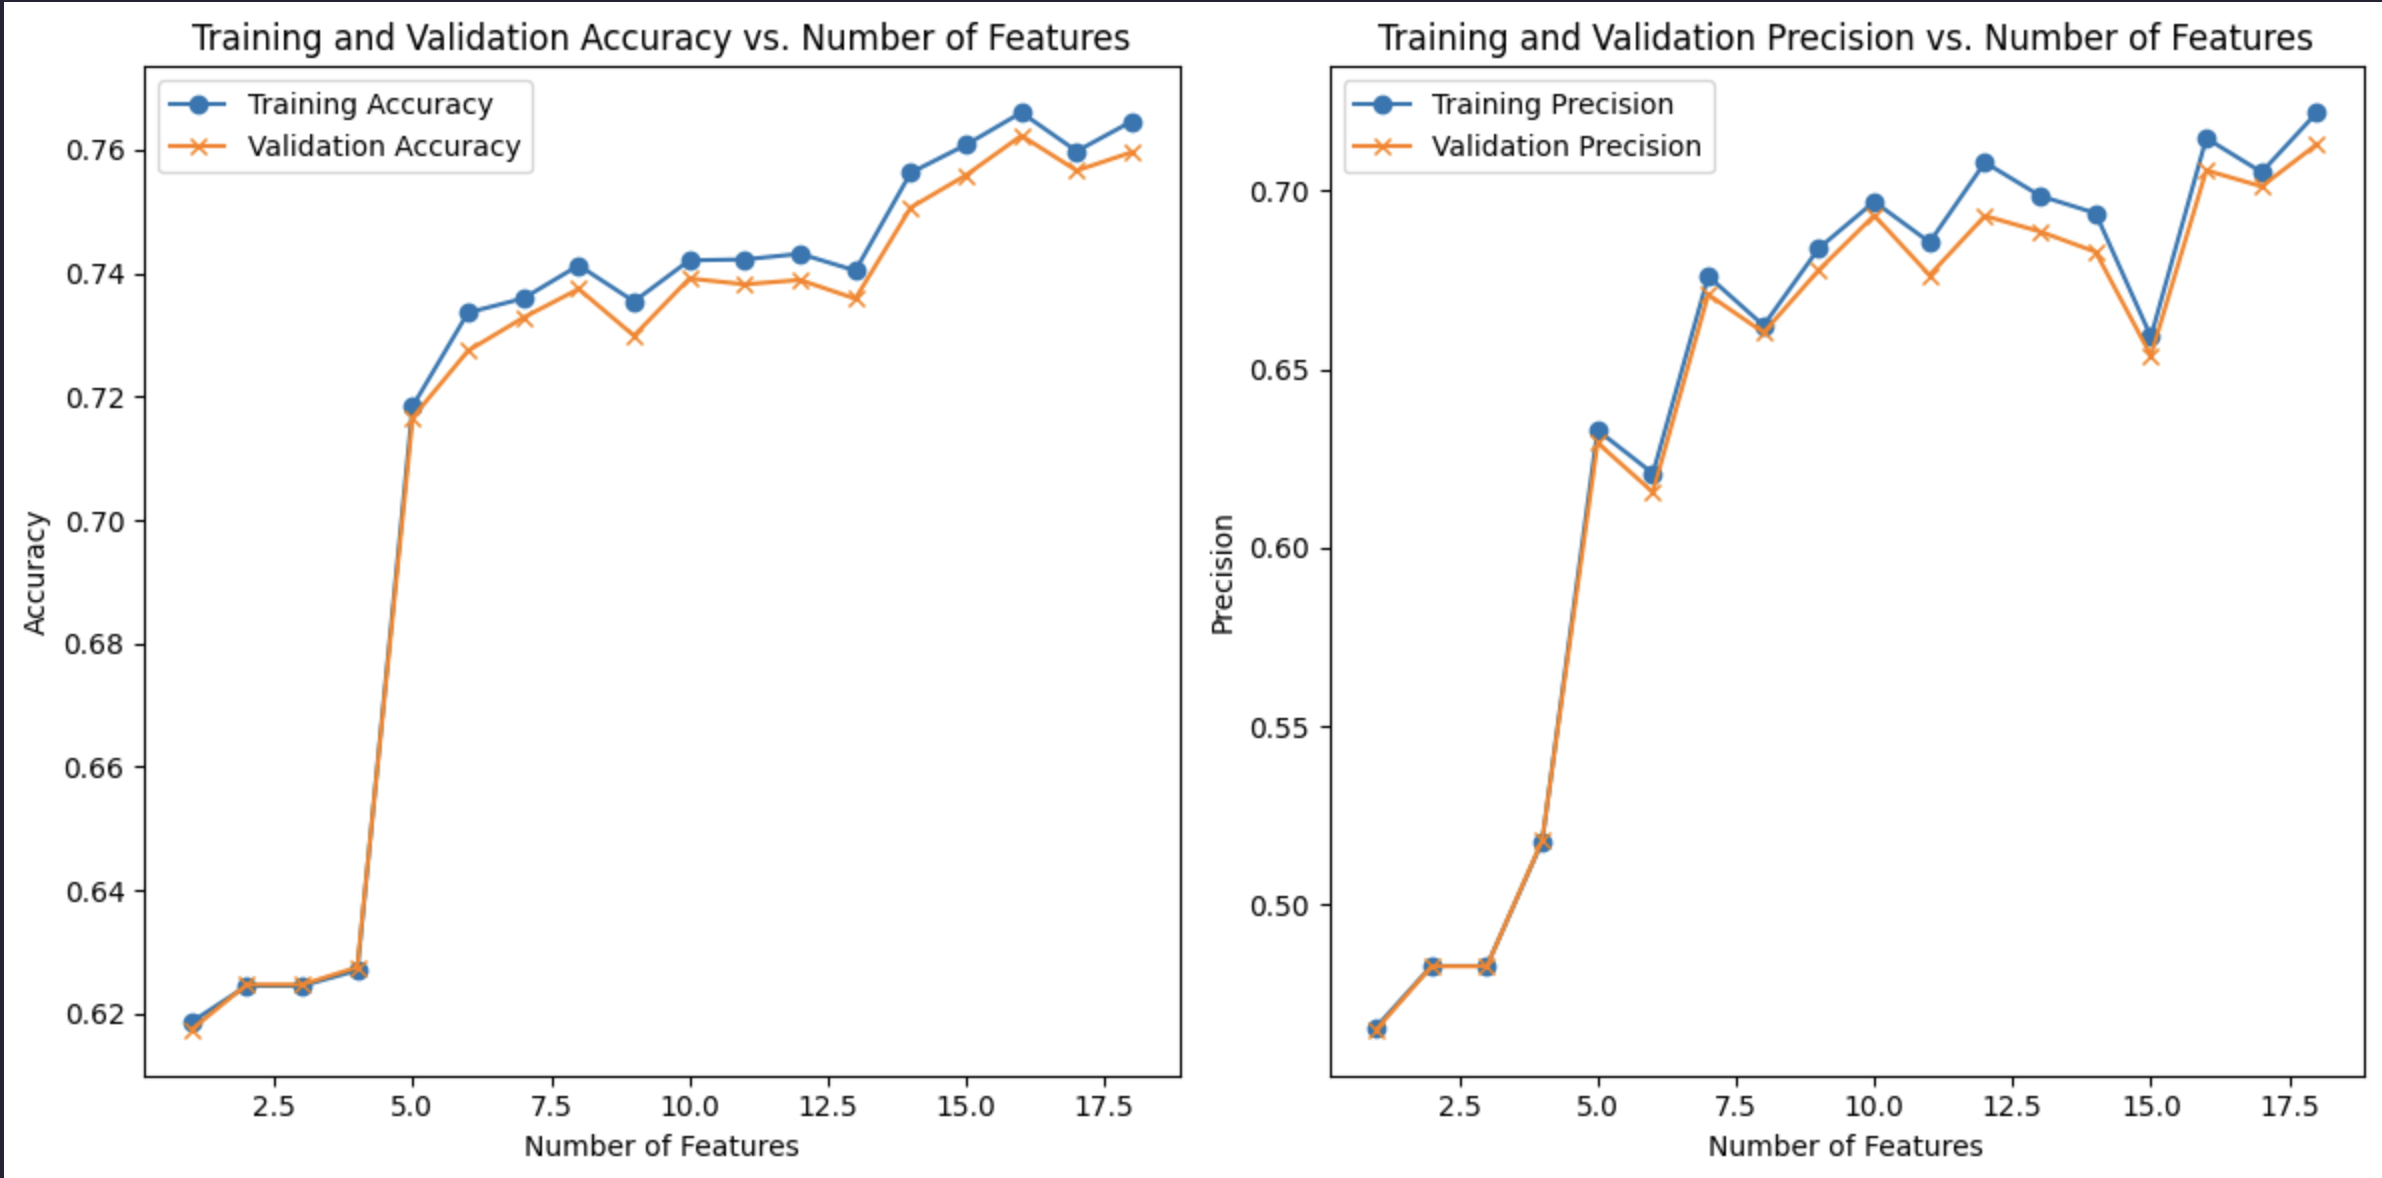
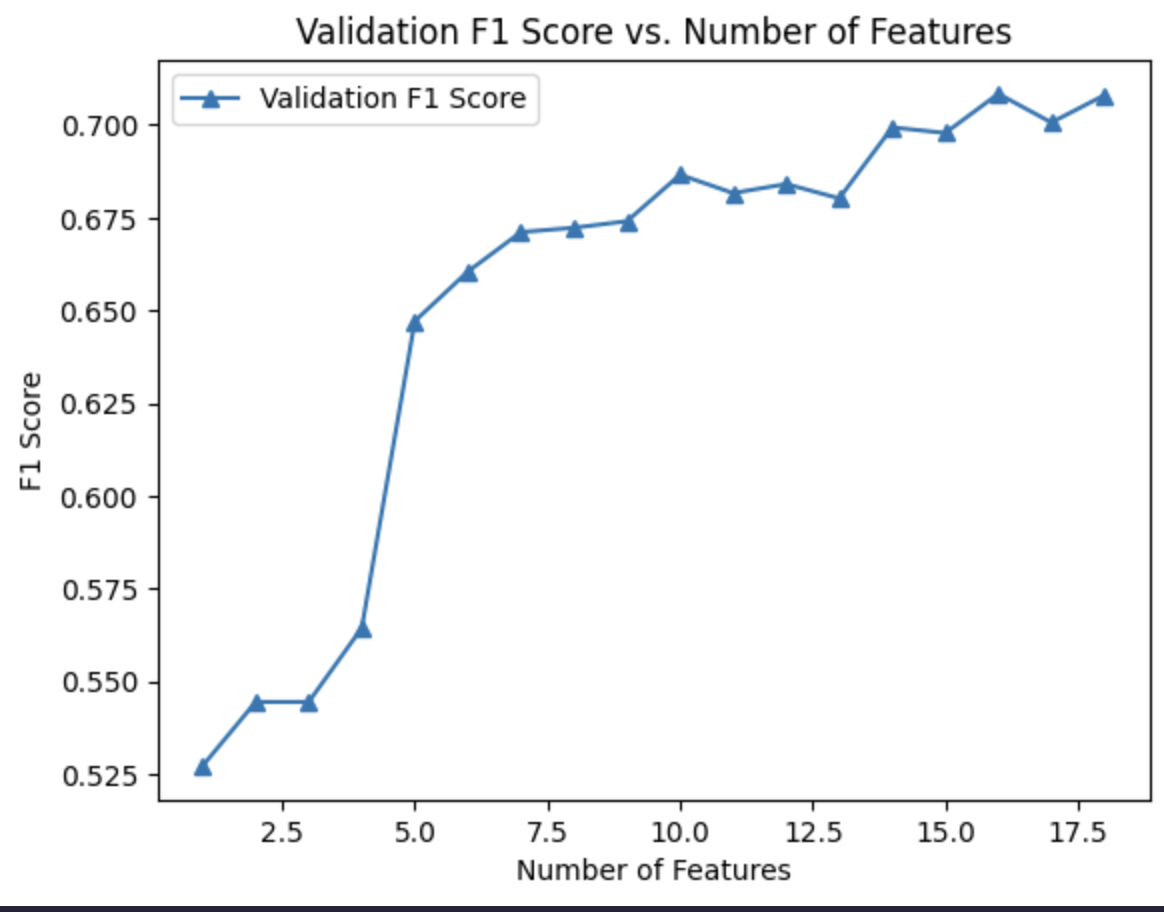

In [11]:
# %%
# Build model with the optimal number of features

train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = test_data_standardized.copy()


# Prepare the data (NOTE: Object names are wrong and misleading here, since after adding more features, the optimal number of features changed)

# THIS predictor_cols_13 IS ACTUALLY SET OF 14 FEATURES
predictor_cols_13 = ['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'District Name', 'First Hearing Date',
       'Gender', 'IME-4 Count', 'Industry Code', 'Days Until Injury Reported']
#This is set with 10 as indicated in the name
predictor_cols_10 = ['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'Gender', 'IME-4 Count']
#This is set with 7 as indicated in the name
predictor_cols_7 = ['Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-3 Date', 'First Hearing Date', 'Gender', 'IME-4 Count']
# THIS predictor_cols_4 IS ACTUALLY SET OF 5 FEATURES
predictor_cols_4 = ['Attorney/Representative', 'Average Weekly Wage', 'C-3 Date',
       'First Hearing Date', 'Gender']


X_train_13 = train_data_NN[predictor_cols_13]
X_train_10 = train_data_NN[predictor_cols_10]
X_train_7 = train_data_NN[predictor_cols_7]
X_train_4 = train_data_NN[predictor_cols_4]

y_train_13 = train_data_NN["Claim Injury Type"]
y_train_10 = train_data_NN["Claim Injury Type"]
y_train_7 = train_data_NN["Claim Injury Type"]
y_train_4 = train_data_NN["Claim Injury Type"]

X_val_13 = val_data_NN[predictor_cols_13]
X_val_10 = val_data_NN[predictor_cols_10]
X_val_7 = val_data_NN[predictor_cols_7]
X_val_4 = val_data_NN[predictor_cols_4]

y_val_13 = val_data_NN["Claim Injury Type"]
y_val_10 = val_data_NN["Claim Injury Type"]
y_val_7 = val_data_NN["Claim Injury Type"]
y_val_4 = val_data_NN["Claim Injury Type"]

test_data_NN = test_data_standardized.copy()
X_test_13 = test_data_NN[predictor_cols_13]
X_test_10 = test_data_NN[predictor_cols_10]
X_test_7 = test_data_NN[predictor_cols_7]
X_test_4 = test_data_NN[predictor_cols_4]

# Build the MLPClassifier with a deep structure and small hidden layers
nn_model_10_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=150 
)

nn_model_13_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=150
)

nn_model_7_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=150
)

nn_model_4_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=150
)


# Train the MLP models
nn_model_10_features.fit(X_train_10, y_train_10)
nn_model_13_features.fit(X_train_13, y_train_13)
nn_model_7_features.fit(X_train_7, y_train_7)
nn_model_4_features.fit(X_train_4, y_train_4)

# Evaluate on training data
train_preds_10 = nn_model_10_features.predict(X_train_10)
accuracy_train_10 = accuracy_score(y_train_10, train_preds_10)
print(f"Training Accuracy with 10 features: {accuracy_train_10}")

# Evaluate on validation data
val_preds_10 = nn_model_10_features.predict(X_val_10)
accuracy_val_10 = accuracy_score(y_val_10, val_preds_10)
f1_val_10 = f1_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Accuracy with 10 features: {accuracy_val_10}")
print(f"Validation F1 Score with 10 features: {f1_val_10}")

# Evaluate precision on validation data
precision_val_10 = precision_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Precision Score with 10 features: {precision_val_10}")

# Same for 12 features
train_preds_13 = nn_model_13_features.predict(X_train_13)
accuracy_train_13 = accuracy_score(y_train_13, train_preds_13)
print(f"Training Accuracy with 14 features: {accuracy_train_13}")

val_preds_13 = nn_model_13_features.predict(X_val_13)
accuracy_val_13 = accuracy_score(y_val_13, val_preds_13)
f1_val_13 = f1_score(y_val_13, val_preds_13, average='weighted')
print(f"Validation Accuracy with 14 features: {accuracy_val_13}")
print(f"Validation F1 Score with 14 features: {f1_val_13}")

precision_val_13 = precision_score(y_val_13, val_preds_13, average='weighted')
print(f"Validation Precision Score with 14 features: {precision_val_13}")


# Same for 7 features
train_preds_7 = nn_model_7_features.predict(X_train_7)
accuracy_train_7 = accuracy_score(y_train_7, train_preds_7)
print(f"Training Accuracy with 7 features: {accuracy_train_7}")

val_preds_7 = nn_model_7_features.predict(X_val_7)
accuracy_val_7 = accuracy_score(y_val_7, val_preds_7)
f1_val_7 = f1_score(y_val_7, val_preds_7, average='weighted')
print(f"Validation Accuracy with 7 features: {accuracy_val_7}")
print(f"Validation F1 Score with 7 features: {f1_val_7}")

precision_val_7 = precision_score(y_val_7, val_preds_7, average='weighted')
print(f"Validation Precision Score with 7 features: {precision_val_7}")


# Same for 5 features
train_preds_4 = nn_model_4_features.predict(X_train_4)
accuracy_train_4 = accuracy_score(y_train_4, train_preds_4)
print(f"Training Accuracy with 5 features: {accuracy_train_4}")

val_preds_4 = nn_model_4_features.predict(X_val_4)
accuracy_val_4 = accuracy_score(y_val_4, val_preds_4)
f1_val_4 = f1_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Accuracy with 5 features: {accuracy_val_4}")
print(f"Validation F1 Score with 5 features: {f1_val_4}")

precision_val_4 = precision_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Precision Score with 5 features: {precision_val_4}")



/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy with 10 features: 0.7460696756307431
Validation Accuracy with 10 features: 0.7429473130533882
Validation F1 Score with 10 features: 0.6849212455996381
Validation Precision Score with 10 features: 0.6918727656543325


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 14 features: 0.7522236541994052
Validation Accuracy with 14 features: 0.7476549487157009
Validation F1 Score with 14 features: 0.6893505414742258
Validation Precision Score with 14 features: 0.6851486549669906


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 7 features: 0.7399224920328967
Validation Accuracy with 7 features: 0.7373104234242132
Validation F1 Score with 7 features: 0.6721198237119397
Validation Precision Score with 7 features: 0.6410075816805832


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 5 features: 0.7224933918908818
Validation Accuracy with 5 features: 0.71948803366354
Validation F1 Score with 5 features: 0.6530833294995247
Validation Precision Score with 5 features: 0.6513742366855497


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# %%
# Save models

# Save the models
joblib.dump(nn_model_10_features, 'nn_model_10_features_wage_c3_first_hearing.pkl')
joblib.dump(nn_model_13_features, 'nn_model_14_features_wage_c3_first_hearing.pkl')
joblib.dump(nn_model_4_features, 'nn_model_5_features_wage_c3_first_hearing.pkl')
joblib.dump(nn_model_7_features, 'nn_model_7_features_wage_c3_first_hearing.pkl')


['nn_model_7_features_wage_c3_first_hearing.pkl']

In [13]:
# %%
# Get predictions for the test data with both models
test_preds_10 = nn_model_10_features.predict(X_test_10)
test_preds_13 = nn_model_13_features.predict(X_test_13)
test_preds_4 = nn_model_4_features.predict(X_test_4)
test_preds_7 = nn_model_7_features.predict(X_test_7)



In [14]:
# %%
# See the unique values in the predictions
unique_values = np.unique(test_preds_10)
print(unique_values)

unique_values_13 = np.unique(test_preds_13)
print(unique_values_13)

unique_values_4 = np.unique(test_preds_4)
print(unique_values_4)

unique_values_7 = np.unique(test_preds_7)
print(unique_values_7)

# Format the predictions according to the required label format
formatted_predictions_10 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_10]
formatted_predictions_13 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_13]
formatted_predictions_4 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_4]
formatted_predictions_7 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_7]

# Create the submission DataFrames
submission_10 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_10
})

submission_13 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_13
})

submission_4 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_4
})

submission_7 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_7
})


# Save to CSV in the required format
submission_10.to_csv("Group39__Version24.csv", index=False)
submission_13.to_csv("Group39__Version25.csv", index=False)
submission_4.to_csv("Group39__Version26.csv", index=False)
submission_7.to_csv("Group39__Version27.csv", index=False)

# Check length of the submission files
print(len(submission_10))
print(len(submission_13))
print(len(submission_4))
print(len(submission_7))

[1 2 3 4 5]
[1 2 3 4 5 6]
[2 3 4 5]
[2 3 4 5]
387975
387975
387975
387975


### Result in kaggle.

* 14 features: 0.20801

* 10 features: 0.29669

* 7 features: 0.26211

* 5 features: 0.26924

## Further NN Model Experiments: Categorial variables Scaling re-visited:

* Train model inside logistic regression RFE (AND LATER TESTING WITH OTHER RFE'S sclaed vs NON-scaled):

    * With scaling for non-numeric columns. Now big values in non-numeric categorial variables can lead to the model emphasizing those big values in categorial variables too much
    
        * We spent a while thinking what could be a good way of scaling these 4 values with high cardinality WITHOUT creating huge amount of new variables.
            * Industry Code
            * WCIO Cause of Injury Code
            * WCIO Nature of Injury Code
            * WCIO Part Of Body Code

        * One-hot encoding would create too much variables (one for each unique value in variable)

        * Target encoding was interesting option from the start since it would not create more variables and it is made for dealing with 
        high cardinality categorical features. We are going to use modified version of it to ensure that we won't create more columns.
        
        * Correct Weighted Average Encoding was chosen for experiment to ensure that we won't create more columns.
            * Compute the overall target class distribution from the training set
            * Compute the class probabilities for each unique value in the categorical column (columns listed above).
            * Replace each value with a single scalar value using the dot product
            * For categories not seen in the training set, replace with the global average

        * HOWEVER. This solution doesn't come without problems:
            * Now that we produce single scalar for each unique value in encoded columns, instead of target class specific numbers for each, we will lose information
            about category-specific relationships with the target variable
            * Our dataset is highly inbalanced when it comes to target variable. In the encoding, majority classes dominate it.

        * Knowing these risks, we are going to try this!
* **This experiment let's us also see, if the logistic regression RFE favors these four categorical features more now that they are scaled**


In [31]:
#Create copies from the original data just in case
train_data_NN_tar_encoding = train_data_standardized.copy()
val_data_NN_tar_encoding = validation_data_standardized.copy()
test_data_NN_tar_encoding = test_data_standardized.copy()


categorical_columns = ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Part Of Body Code', 'WCIO Nature of Injury Code']
target_column = 'Claim Injury Type'


def weighted_average_encode(train, val, test, cols, target):
    global_class_probs = train[target].value_counts(normalize=True).values  # Global class probabilities
    for col in cols:
        # Calculate probabilities for each category
        category_probs = (
            train.groupby(col)[target]
            .value_counts(normalize=True)  # Get class probabilities
            .unstack(fill_value=0)         # Convert to wide format
        )

        # Replace each category with its weighted average
        def compute_weighted_average(value):
            if value in category_probs.index:
                return np.dot(category_probs.loc[value], global_class_probs)  # Dot product
            else:
                return np.dot(global_class_probs, global_class_probs)  # Fallback for unseen categories

        # Apply weighted averages to train, val, and test sets
        train[col] = train[col].apply(compute_weighted_average)
        val[col] = val[col].apply(compute_weighted_average)
        test[col] = test[col].apply(compute_weighted_average)
    
    return train, val, test

# Apply encoding
train_data_NN_tar_encoding, val_data_NN_tar_encoding, test_data_NN_tar_encoding = weighted_average_encode(
    train_data_NN_tar_encoding, val_data_NN_tar_encoding, test_data_NN_tar_encoding, categorical_columns, target_column
)



In [16]:
train_data_NN_tar_encoding.head()

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,C-3 Date,Carrier Type,Claim Injury Type,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,,,
6057673,-1.266515,1.158054,-1.223194,0,0.143750,-1.200452,0,1,2,1,0,1,-0.419308,0.150971,0.191799,0.183166,0.152129,-0.502881,-0.343428
5918256,-0.641131,0.566319,-0.644960,0,0.076640,-0.626157,0,2,2,5,0,1,-0.419308,0.163972,0.187909,0.208889,0.225275,-0.502881,-0.087336
6054143,-1.233121,0.492352,-1.204131,0,-0.559685,-1.181519,0,2,4,1,0,2,-0.419308,0.192437,0.159736,0.160029,0.187883,0.997085,-0.290075
6009943,-1.038827,0.492352,-1.023036,1,1.715827,-1.001657,1,1,4,5,1,2,2.102156,0.181433,0.159608,0.177017,0.150458,-1.002870,-0.215382
5627232,0.515527,-1.060955,0.644947,0,-0.841125,0.654962,0,3,2,2,0,1,-0.419308,0.197981,0.163270,0.208889,0.200321,0.497096,-0.354098


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 1
Selected features:  Index(['WCIO Nature of Injury Code'], dtype='object')
Training Accuracy: 0.5040871749455836
Validation Accuracy: 0.4978609625668449
Validation F1 Score: 0.35273374982292055
Validation Precision Score: 0.3083058200983488
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 2
Selected features:  Index(['Industry Code', 'WCIO Nature of Injury Code'], dtype='object')
Training Accuracy: 0.5271402459326437
Validation Accuracy: 0.5253616200578592
Validation F1 Score: 0.4458531364644101
Validation Precision Score: 0.4390273417654886
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 3
Selected features:  Index(['Industry Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.5366124352495906
Validation Accuracy: 0.5320943280441834
Validation F1 Score: 0.4369604757961562
Validation Precision Score: 0.42648006859731463
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 4
Selected features:  Index(['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.5399804757838566
Validation Accuracy: 0.5378364162356448
Validation F1 Score: 0.46312079989531657
Validation Precision Score: 0.4365011007230835
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 5
Selected features:  Index(['First Hearing Date', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.6333682896831958
Validation Accuracy: 0.630805645656176
Validation F1 Score: 0.5602008004692013
Validation Precision Score: 0.5385737272268343
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 6
Selected features:  Index(['Attorney/Representative', 'First Hearing Date', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.6498642138332016
Validation Accuracy: 0.6482423073551328
Validation F1 Score: 0.5940399284945531
Validation Precision Score: 0.5544980294453857
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 7
Selected features:  Index(['Attorney/Representative', 'C-3 Date', 'First Hearing Date',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.6500499430354947
Validation Accuracy: 0.64875076707285
Validation F1 Score: 0.5920757082015704
Validation Precision Score: 0.5537816861474201
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 8
Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'C-3 Date',
       'First Hearing Date', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7462644647941237
Validation Accuracy: 0.7443937932848251
Validation F1 Score: 0.6841803767031103
Validation Precision Score: 0.6841394221231809
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 9
Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'C-3 Date',
       'First Hearing Date', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7588849905889654
Validation Accuracy: 0.7560533006048917
Validation F1 Score: 0.6977894132388558
Validation Precision Score: 0.7060633289276542
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 10
Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7584251975637765
Validation Accuracy: 0.7556325063557465
Validation F1 Score: 0.6980073778610496
Validation Precision Score: 0.6941772813722225
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 11
Selected features:  Index(['Accident Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'C-3 Date', 'First Hearing Date', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7635304856365642
Validation Accuracy: 0.7611904970632069
Validation F1 Score: 0.7032608582287173
Validation Precision Score: 0.7200047562700443
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 12
Selected features:  Index(['Accident Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'C-3 Date', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7638928840800628
Validation Accuracy: 0.7582800035066187
Validation F1 Score: 0.7029770484424523
Validation Precision Score: 0.6919118093225194
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 13
Selected features:  Index(['Accident Date', 'Assembly Date', 'Attorney/Representative',
       'Average Weekly Wage', 'C-2 Date', 'C-3 Date', 'First Hearing Date',
       'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.760608648185856
Validation Accuracy: 0.7550539142631717
Validation F1 Score: 0.6981039755667534
Validation Precision Score: 0.7040453053471023
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 14
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7576188610269919
Validation Accuracy: 0.7542561584991672
Validation F1 Score: 0.701805496793284
Validation Precision Score: 0.6951409376804596
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 15
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7640083985839281
Validation Accuracy: 0.7596563513631981
Validation F1 Score: 0.7129429290198656
Validation Precision Score: 0.6994118721103526
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 16
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Days Until Injury Reported',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7624070504617183
Validation Accuracy: 0.7587270973963356
Validation F1 Score: 0.7073883923201852
Validation Precision Score: 0.7089413884617338
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 17
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7591431994799582
Validation Accuracy: 0.7557201718243184
Validation F1 Score: 0.6991585654691743
Validation Precision Score: 0.6908498364002021
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 18
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.761867982777014
Validation Accuracy: 0.7573595160866134
Validation F1 Score: 0.7026234665120328
Validation Precision Score: 0.7151547231387555
--------------------------------------------------


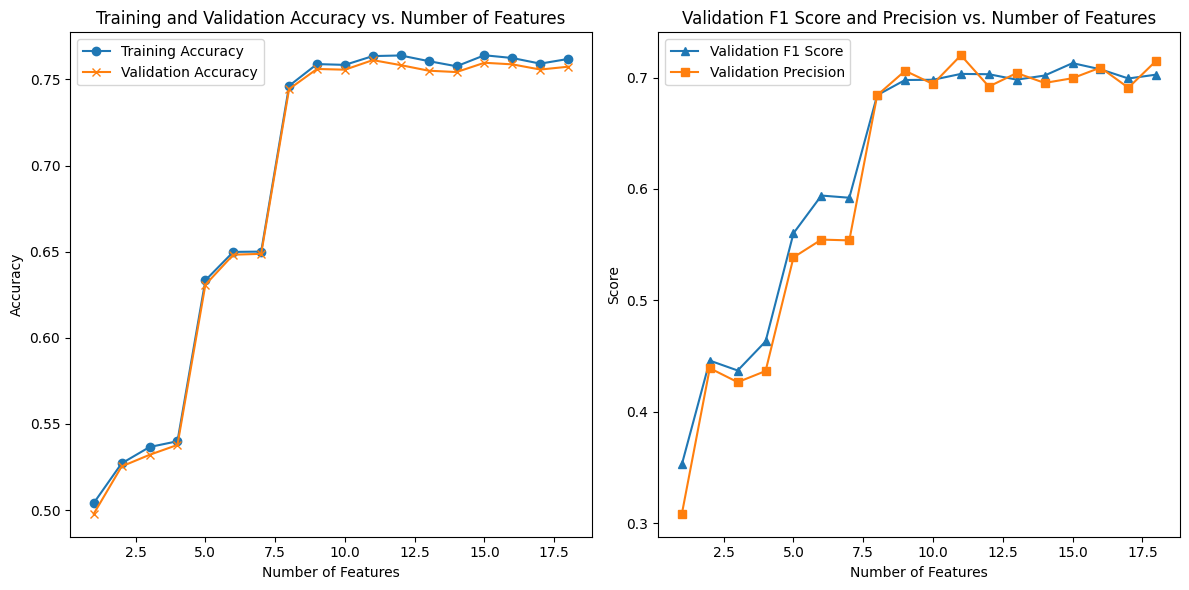

In [21]:
# %%
train_data_NN = train_data_NN_tar_encoding.copy()
val_data_NN = val_data_NN_tar_encoding.copy()
test_data_NN = test_data_NN_tar_encoding.copy()


# Prepare the data
predictor_cols = train_data_NN.columns.difference(["Claim Injury Type"])

X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
precision_val = []
num_feature_list = list(range(1, num_features + 1))

# Use LogisticRegression as the base estimator for RFE
base_estimator = LogisticRegression(max_iter=1500)  

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=200
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Evaluate precision on validation data
    precision_on_val = precision_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)
    precision_val.append(precision_on_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print(f"Validation Precision Score: {precision_on_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score and Precision
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.plot(num_feature_list, precision_val, label='Validation Precision', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Validation F1 Score and Precision vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()




## Try four most promising set of features and make Kaggle returns with them

* Set of features chosen are:
  * 8 features: Chosen for being least complex model and no significant improvements in mterics are seen with adding more features
  * 10 features: Chosen for adding more complexity than 8 features, with slightly better precision, accuracy and f1-score
  * 11 features: Chosen for having the highest precision while still retaining relatively high accuracy and f1-score
  * 15 features: Chosen as the most complex model. Has highest accuracy and f1-score
    
* Surprisingly after encoding the four categorial column, previously left un-scaled, the Logistic Regression RFE favored them in the beginning. **Based on metrics with Neural Network, these columns are not the best predictors for the target column while using NN's.**
  * After addition of these columns to model, the accuracy is under 0.55 and precision and f1-score under 0.5 as well.


  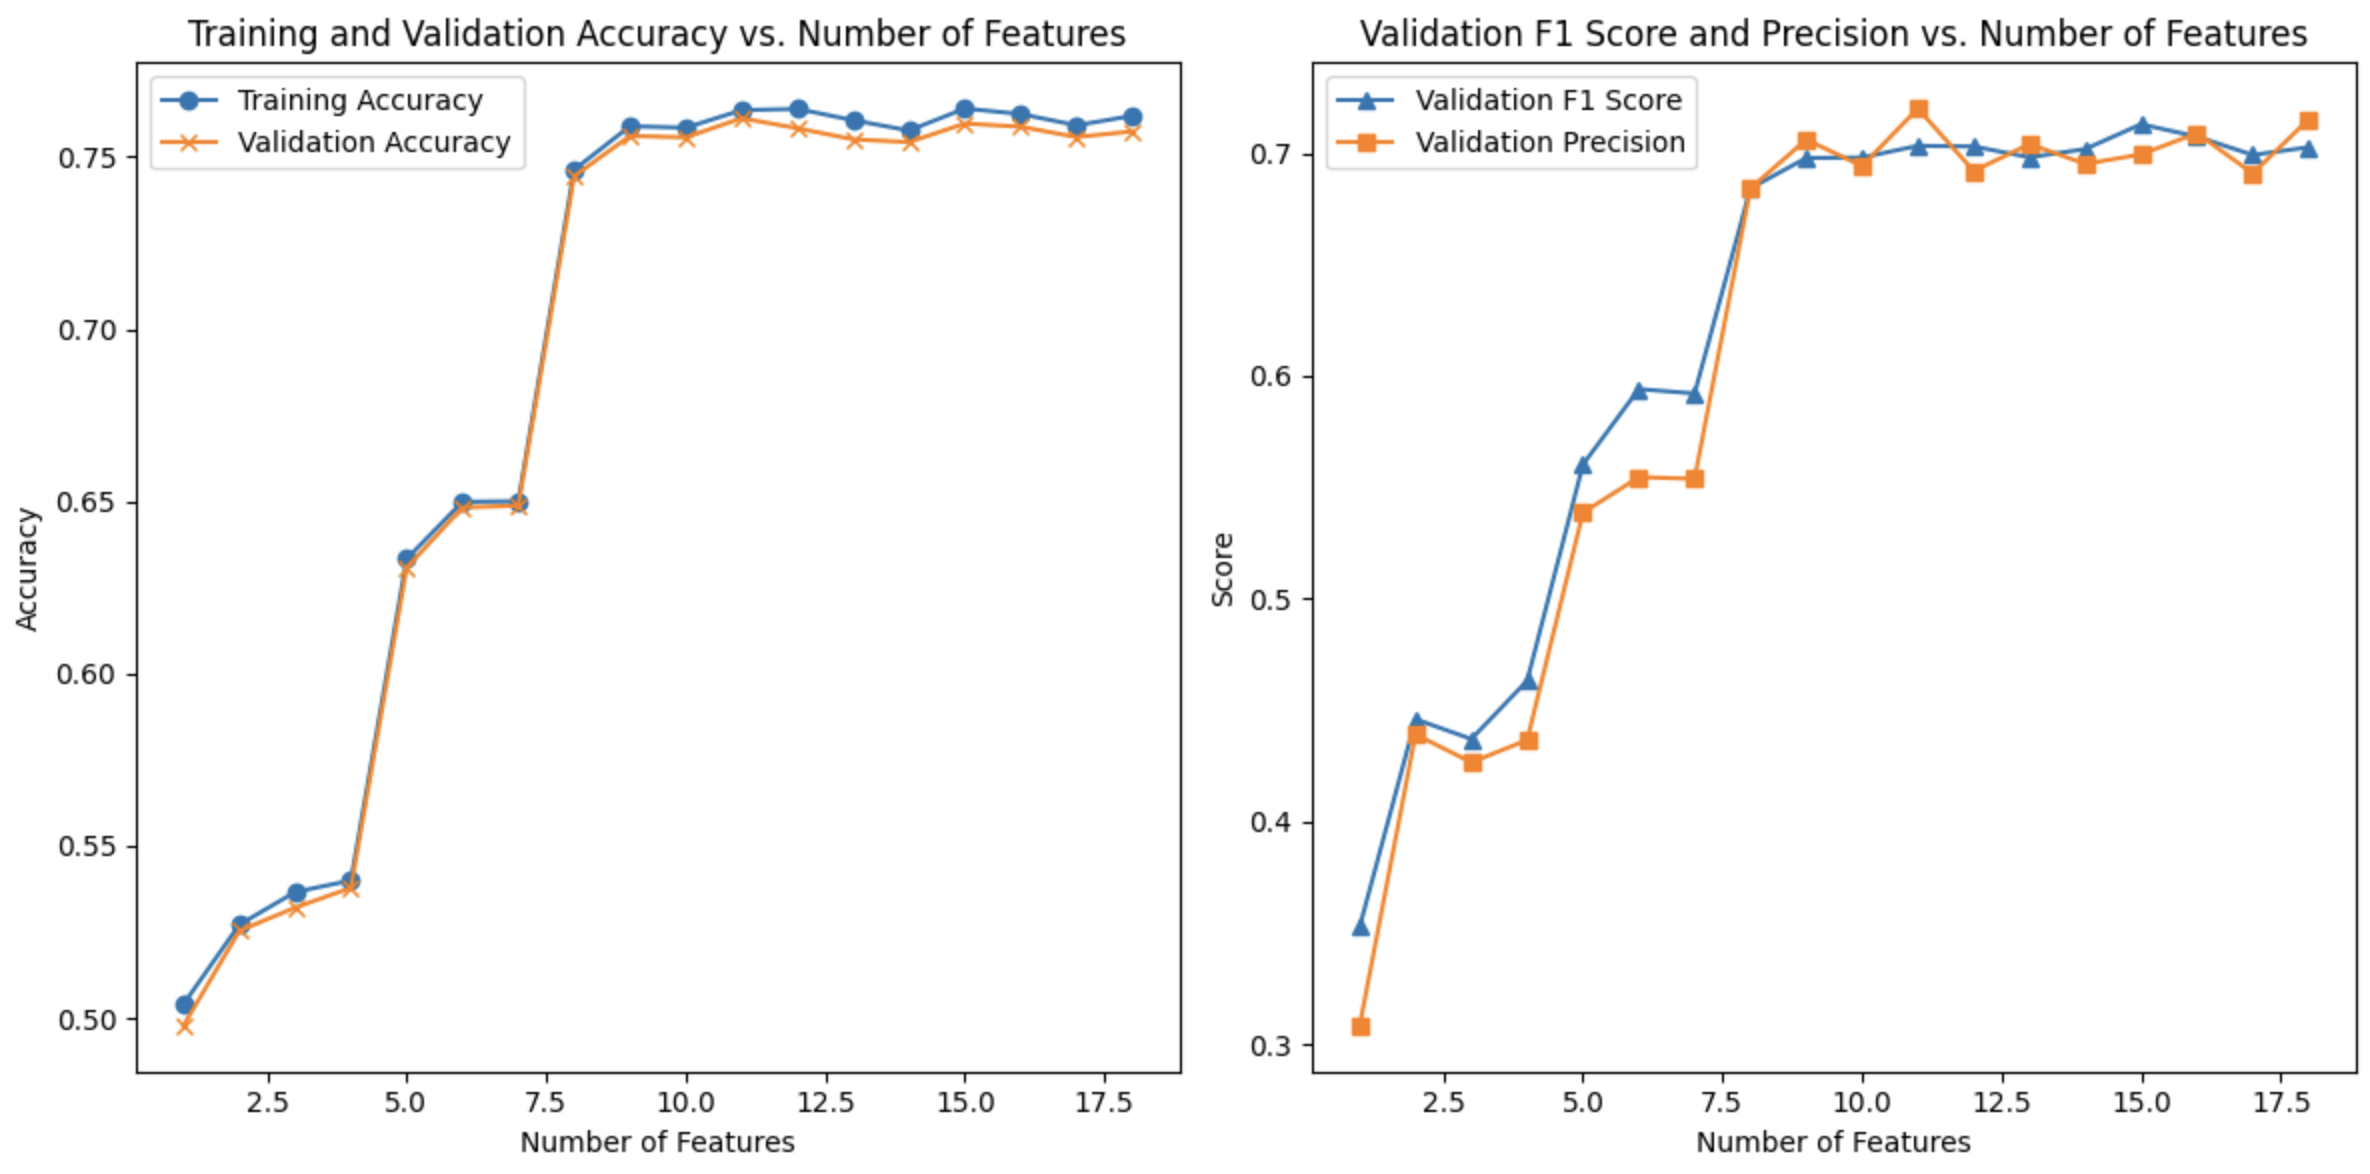

In [22]:
# %%
# Build model with the optimal number of features

train_data_NN = train_data_NN_tar_encoding.copy()
val_data_NN = val_data_NN_tar_encoding.copy()
test_data_NN = test_data_NN_tar_encoding.copy()

# Prepare the data

#NOTE: THE VARIABLE NAMES ARE MISLEADING, SINCE THE NUMBER OF FEATURES CHANGED AFTER ADDING MORE FEATURES
predictor_cols_4 = ['Attorney/Representative', 'Average Weekly Wage', 'C-3 Date',
       'First Hearing Date', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
predictor_cols_6 = ['Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code']
predictor_cols_10 = ['Accident Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'C-3 Date', 'First Hearing Date', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
predictor_cols_11 = ['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'C-3 Date', 'Carrier Type', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']


X_4 = train_data_NN[predictor_cols_4]
X_6 = train_data_NN[predictor_cols_6]
X_10 = train_data_NN[predictor_cols_10]
X_11 = train_data_NN[predictor_cols_11]

y_4 = train_data_NN["Claim Injury Type"]
y_6 = train_data_NN["Claim Injury Type"]
y_10 = train_data_NN["Claim Injury Type"]
y_11 = train_data_NN["Claim Injury Type"]

X_val_4 = val_data_NN[predictor_cols_4]
X_val_6 = val_data_NN[predictor_cols_6]
X_val_10 = val_data_NN[predictor_cols_10]
X_val_11 = val_data_NN[predictor_cols_11]

y_val_4 = val_data_NN["Claim Injury Type"]
y_val_6 = val_data_NN["Claim Injury Type"]
y_val_10 = val_data_NN["Claim Injury Type"]
y_val_11 = val_data_NN["Claim Injury Type"]

X_test_4 = test_data_NN[predictor_cols_4]
X_test_6 = test_data_NN[predictor_cols_6]
X_test_10 = test_data_NN[predictor_cols_10]
X_test_11 = test_data_NN[predictor_cols_11]


nn_model_4_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=350
)

nn_model_6_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=350
)

nn_model_10_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=350
)

nn_model_11_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=350  
)


# Train the MLP model
nn_model_4_features.fit(X_4, y_4)
nn_model_6_features.fit(X_6, y_6)
nn_model_10_features.fit(X_10, y_10)
nn_model_11_features.fit(X_11, y_11)

# Evaluate on training data
train_preds_11 = nn_model_11_features.predict(X_11)
accuracy_train_11 = accuracy_score(y_11, train_preds_11)
print(f"Training Accuracy with 15 features: {accuracy_train_11}")

# Evaluate on validation data
val_preds_11 = nn_model_11_features.predict(X_val_11)
accuracy_val_11 = accuracy_score(y_val_11, val_preds_11)
f1_val_11 = f1_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Accuracy with 15 features: {accuracy_val_11}")
print(f"Validation F1 Score with 15 features: {f1_val_11}")

# Evaluate precision on validation data
precision_val_11 = precision_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Precision Score with 15 features: {precision_val_11}")

# Evaluate recall on validation data
recall_val_11 = recall_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Recall Score with 15 features: {recall_val_11}")

# Same for 11 features

train_preds_10 = nn_model_10_features.predict(X_10)
accuracy_train_10 = accuracy_score(y_10, train_preds_10)
print(f"Training Accuracy with 11 features: {accuracy_train_10}")

val_preds_10 = nn_model_10_features.predict(X_val_10)
accuracy_val_10 = accuracy_score(y_val_10, val_preds_10)
f1_val_10 = f1_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Accuracy with 11 features: {accuracy_val_10}")
print(f"Validation F1 Score with 11 features: {f1_val_10}")

precision_val_10 = precision_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Precision Score with 11 features: {precision_val_10}")

recall_val_10 = recall_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Recall Score with 11 features: {recall_val_10}")

# Same for 10 features

train_preds_6 = nn_model_6_features.predict(X_6)
accuracy_train_6 = accuracy_score(y_6, train_preds_6)
print(f"Training Accuracy with 10 features: {accuracy_train_6}")

val_preds_6 = nn_model_6_features.predict(X_val_6)
accuracy_val_6 = accuracy_score(y_val_6, val_preds_6)
f1_val_6 = f1_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Accuracy with 10 features: {accuracy_val_6}")
print(f"Validation F1 Score with 10 features: {f1_val_6}")

precision_val_6 = precision_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Precision Score with 10 features: {precision_val_6}")

recall_val_6 = recall_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Recall Score with 10 features: {recall_val_6}")


# Same for 4 features

train_preds_4 = nn_model_4_features.predict(X_4)
accuracy_train_4 = accuracy_score(y_4, train_preds_4)
print(f"Training Accuracy with 8 features: {accuracy_train_4}")

val_preds_4 = nn_model_4_features.predict(X_val_4)
accuracy_val_4 = accuracy_score(y_val_4, val_preds_4)
f1_val_4 = f1_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Accuracy with 8 features: {accuracy_val_4}")
print(f"Validation F1 Score with 8 features: {f1_val_4}")

precision_val_4 = precision_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Precision Score with 8 features: {precision_val_4}")

recall_val_4 = recall_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Recall Score with 8 features: {recall_val_4}")



Training Accuracy with 15 features: 0.7654013676011262
Validation Accuracy with 15 features: 0.7615762251249233
Validation F1 Score with 15 features: 0.7125470722907833
Validation Precision Score with 15 features: 0.7112301280777392
Validation Recall Score with 15 features: 0.7615762251249233


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 11 features: 0.767358319196019
Validation Accuracy with 11 features: 0.7649162794775138
Validation F1 Score with 11 features: 0.7119926120176397
Validation Precision Score with 11 features: 0.7148405383114906
Validation Recall Score with 11 features: 0.7649162794775138


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 10 features: 0.7611748957538227
Validation Accuracy with 10 features: 0.7583939686157622
Validation F1 Score with 10 features: 0.7005090487365977
Validation Precision Score with 10 features: 0.6842249192382677
Validation Recall Score with 10 features: 0.7583939686157622


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 8 features: 0.7474875595409318
Validation Accuracy with 8 features: 0.7459367055316911
Validation F1 Score with 8 features: 0.6850704142465073
Validation Precision Score with 8 features: 0.6660054752944826
Validation Recall Score with 8 features: 0.7459367055316911


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# %%
# Save models

# Save the models
joblib.dump(nn_model_11_features, 'nn_model_15_features_log_rfe_mod_tar_encoding.pkl')
joblib.dump(nn_model_10_features, 'nn_model_11_features_log_rfe_mod_tar_encoding.pkl')
joblib.dump(nn_model_6_features, 'nn_model_10_features_log_rfe_mod_tar_encoding.pkl')
joblib.dump(nn_model_4_features, 'nn_model_8_features_log_rfe_mod_tar_encoding.pkl')


['nn_model_8_features_log_rfe_mod_tar_encoding.pkl']

In [33]:
# %%
# Get predictions for the test data with all models
test_preds_4 = nn_model_4_features.predict(X_test_4)
test_preds_6 = nn_model_6_features.predict(X_test_6)
test_preds_10 = nn_model_10_features.predict(X_test_10)
test_preds_11 = nn_model_11_features.predict(X_test_11)

# See the unique values in the predictions
unique_values = np.unique(test_preds_11)
print(unique_values)

unique_values_10 = np.unique(test_preds_10)
print(unique_values_10)

unique_values_6 = np.unique(test_preds_6)
print(unique_values_6)

unique_values_4 = np.unique(test_preds_4)
print(unique_values_4)

# Format the predictions according to the required label format
formatted_predictions_11 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_11]
formatted_predictions_10 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_10]
formatted_predictions_6 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_6]
formatted_predictions_4 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_4]

print(len(formatted_predictions_11))

# Create the submission DataFrames
submission_11 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_11
})

submission_10 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_10
})

submission_6 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_6
})

submission_4 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_4
})



# Save to CSV in the required format
submission_11.to_csv("Group39__Version29.csv", index=False)
submission_10.to_csv("Group39__Version30.csv", index=False)
submission_6.to_csv("Group39__Version31.csv", index=False)
submission_4.to_csv("Group39__Version32.csv", index=False)

# Check length of the submission files
print(len(submission_11))
print(len(submission_10))
print(len(submission_6))
print(len(submission_4))


[1 2 3 4 5 8]
[1 2 3 4 5 8]
[1 2 3 4 5]
[1 2 3 4 5]
387975
387975
387975
387975
387975


 ## Results in Kaggle:
 * Results in Kaggle for all datasets were really bad (see image for the three first one's we tried the kaggle submission). For Neural Networks, this categorial variable encoding method that we tried, resulted in bad f-1 score with training set.
 * Encoding probably misled or distorted the data in a way that the NN was making false interepretations with it.

 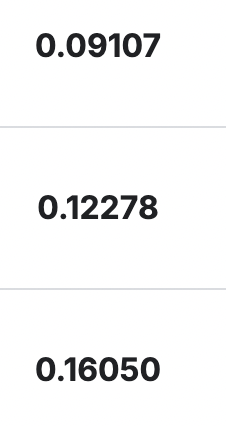

 ## OUTDATED!: (CODE ABOUT SMOTE COMMENTED OUT AND TRIED AFTER IMPORTANT FIXING OF PREPROCESSING )Further NN Model Experiments: Target value imbalance

 * Train model inside RFE and then with 3 best sets of features found this far (according to local environment assessment as well as Kaggle competition f1 score)

     * Before training, apply Oversampling, Undersampling or SMOTE Techniques to get more minority result class values to the training. Our model is probably not good in predicting for those minoriity target variable value classes.

 * Training iterations of predictor features:

     * Inside RFE to find best set of features:

         * Inside RFE without assembly and accident date

     * Predict for two best sets from both RFE procesure above

     * Best 3 sets of previous experiments:

         * See if modifications to SMOTE are needed





 ## Chosen method: Creating synthetic minority class data with SMOTE

 * We chose SMOTE and not oversampling, since duplicating minority class members a lot, we might add risk for overfitting

In [ ]:
# %%
# # Check the target value counts in train data
# train_data_balanced = train_data_non_standardized.copy()


# train_data_balanced['Claim Injury Type'].value_counts()


# # Prepare the data
# predictor_cols = train_data_balanced.columns[train_data_balanced.columns != "Claim Injury Type"]
# X = train_data_balanced[predictor_cols]
# y = train_data_balanced["Claim Injury Type"]

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# # We set a custom sampling strategy to reduce the amount of created syntetic samples and to keep the size of dataset OK 
# # From value count we saw that Majority class has 282253 samples. For minority classes that have less than 25% of the majority class samples are 3,5,1,6,8 and 7. For those classes we will set the sampling strategy to 0.25
# # So we are adding synthetic samples to minority classes to have 25% of the majority class samples

# """
# value counts
# 2    282253
# 4    141022
# 3     67250
# 5     46867
# 1     10058
# 6      3945
# 8       431
# 7        69
# """

# target_size = int(0.25 * 282253)

# # Define sampling strategy as a dictionary
# # Only include classes with fewer samples than target_size (70563). 
# sampling_strategy = {
#     3: target_size,  # Currently 67250 -> Increase to 70563
#     5: target_size,  # Currently 46867 -> Increase to 70563
#     1: target_size,  # Currently 10058 -> Increase to 70563
#     6: target_size,  # Currently 3945 -> Increase to 70563
#     7: target_size,  # Currently 69 -> Increase to 70563
#     8: target_size,  # Currently 431 -> Increase to 70563
# }



# # Apply SMOTE 
# smote = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# # Convert the resampled data back to a DataFrame
# X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled_df = pd.DataFrame(y_resampled, columns=['Claim Injury Type'])
# train_data_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# # Check for lenght of data and value counts in the resampled data
# print(len(train_data_resampled))
# train_data_resampled['Claim Injury Type'].value_counts()




 ## Model Training with new balanced training data

In [ ]:
# %%
# # RFE WITH ALL FEATURES (for SMOTE'd data)

# train_data_NN = train_data_resampled.copy()
# test_data_NN  = test_data_non_standardized.copy()


# # Prepare the data
# predictor_cols = train_data_NN.columns.difference(["Claim Injury Type", "Accident Date", "Assembly Date"])
# X = train_data_NN[predictor_cols]
# y = train_data_NN["Claim Injury Type"]


# # Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# # Define the total number of features in the dataset
# num_features = X.shape[1]





# %%

# # Lists to store the results for plotting
# accuracy_scores_train = []
# accuracy_scores_val = []
# f1_scores_val = []
# num_feature_list = list(range(1, num_features + 1))

# # Use LogisticRegression as the base estimator for RFE
# base_estimator = LogisticRegression(max_iter=1000)  

# # Loop over feature numbers from 1 to the total number of features
# for n_features in num_feature_list:
#     # Use RFE to select n_features
#     rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
#     rfe.fit(X_train, y_train)
#     selected_features = rfe.support_

#     #NOTE: THIS FOR NUMPY!
#     # Select the features from training and validation sets
#     # X_train_rfe = X_train[:, selected_features]
#     # X_val_rfe = X_val[:, selected_features]

#     #NOTE: THIS FOR DATAFRAMES!
#     selected_columns = X_train.columns[selected_features] # Get the selected column names
#     X_train_rfe = X_train[selected_columns]
#     X_val_rfe = X_val[selected_columns]

    
#     # Build the MLPClassifier with a deep structure and small hidden layers
#     mlp = MLPClassifier(
#         hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
#         activation='relu',
#         solver='adam',
#         max_iter=200  
#     )

#     # Train the MLP model
#     mlp.fit(X_train_rfe, y_train)

#     # Evaluate on training data
#     train_preds = mlp.predict(X_train_rfe)
#     accuracy_train = accuracy_score(y_train, train_preds)

#     # Evaluate on validation data
#     val_preds = mlp.predict(X_val_rfe)
#     accuracy_val = accuracy_score(y_val, val_preds)
#     f1_val = f1_score(y_val, val_preds, average='weighted')

#     # Store results
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_val.append(accuracy_val)
#     f1_scores_val.append(f1_val)

#     # Get selected feature names
#     selected_features_names = selected_columns
#     # Print results for each feature set
#     print(f"Number of features: {n_features}")
#     print("Selected features: ", selected_features_names)
#     print(f"Training Accuracy: {accuracy_train}")
#     print(f"Validation Accuracy: {accuracy_val}")
#     print(f"Validation F1 Score: {f1_val}")
#     print("-" * 50)

# # Plotting accuracy and F1 scores for different feature counts
# plt.figure(figsize=(12, 6))

# # Plot Training and Validation Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
# plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy vs. Number of Features')
# plt.legend()

# # Plot Validation F1 Score
# plt.subplot(1, 2, 2)
# plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
# plt.xlabel('Number of Features')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Score vs. Number of Features')
# plt.legend()

# plt.tight_layout()
# plt.show()




 Next we will train models with 4 most promising set of features with even more iterations allowed for the NN and save the model.

 * Set 1: Three features: ['Attorney/Representative', 'IME-4 Count', 'WCIO Nature of Injury Code']

     * We want to explore this since it was the first set of features that pumped up the accuracy radically

 * Set 2: Nine features: ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

     * We want to explore this since it was the set of features, which after, we didn't significally prove accuracy or f1-score

 * Set 3: Thirteen features: All but Assemly Date and Age at Injury

     * We want to explore this since it was the set that produced overall highest accuracies and f1-scores

 * Set 4: All the features that improved training and validation accracy and f1-score:

     * Selected features: ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Type']

     * We want to explore this since we want to try how the result comes up with only the features that improved the metrics from the previous iteration of RFE process

In [ ]:
# %%
# # Apply smote to all datasets

# # Check the target value counts in train data
# train_data_balanced = train_data_non_standardized.copy()
# test_data_balanced = test_data_non_standardized.copy()

# # Prepare the data
# predictor_cols_all = train_data_NN.columns.difference(["Claim Injury Type", "Accident Date", "Assembly Date"])
# predictor_cols_3 = ['Attorney/Representative', 'IME-4 Count', 'WCIO Nature of Injury Code'] 
# predictor_cols_9 = ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
# predictor_cols_improved = ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Type']


# X_all = train_data_NN[predictor_cols_all]
# X_3 = train_data_NN[predictor_cols_3]
# X_9 = train_data_NN[predictor_cols_9]
# X_improved = train_data_NN[predictor_cols_improved]

# y_all = train_data_NN["Claim Injury Type"]
# y_3 = train_data_NN["Claim Injury Type"]
# y_9 = train_data_NN["Claim Injury Type"]
# y_improved = train_data_NN["Claim Injury Type"]



# # Scale the data
# scaler_all = StandardScaler()
# scaler_3 = StandardScaler()
# scaler_9 = StandardScaler()
# scaler_improved = StandardScaler()

# X_scaled_all = scaler_all.fit_transform(X_all)
# X_scaled_3 = scaler_3.fit_transform(X_3)
# X_scaled_9 = scaler_9.fit_transform(X_9)
# X_scaled_improved = scaler_improved.fit_transform(X_improved)

# # Prepeare test data
# test_data_NN_all = test_data_NN[predictor_cols_all]
# test_data_NN_3 = test_data_NN[predictor_cols_3]
# test_data_NN_9 = test_data_NN[predictor_cols_9]
# test_data_NN_improved = test_data_NN[predictor_cols_improved]

# # Scale the test data
# test_data_NN_all = scaler_all.transform(test_data_NN_all)
# test_data_NN_3 = scaler_3.transform(test_data_NN_3)
# test_data_NN_9 = scaler_9.transform(test_data_NN_9)
# test_data_NN_improved = scaler_improved.transform(test_data_NN_improved)

# # We set a custom sampling strategy to reduce the amount of created syntetic samples and to keep the size of dataset OK 
# # From value count we saw that Majority class has 282253 samples. For minority classes that have less than 25% of the majority class samples are 3,5,1,6,8 and 7. For those classes we will set the sampling strategy to 0.25
# # So we are adding synthetic samples to minority classes to have 25% of the majority class samples

# """
# value counts
# 2    282253
# 4    141022
# 3     67250
# 5     46867
# 1     10058
# 6      3945
# 8       431
# 7        69
# """

# target_size = int(0.25 * 282253)

# # Define sampling strategy as a dictionary
# # Only include classes with fewer samples than target_size (70563). 
# sampling_strategy = {
#     3: target_size,  # Currently 67250 -> Increase to 70563
#     5: target_size,  # Currently 46867 -> Increase to 70563
#     1: target_size,  # Currently 10058 -> Increase to 70563
#     6: target_size,  # Currently 3945 -> Increase to 70563
#     7: target_size,  # Currently 69 -> Increase to 70563
#     8: target_size,  # Currently 431 -> Increase to 70563
# }



# # Apply SMOTE 
# smote_all = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_3 = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_9 = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_improved = SMOTE(sampling_strategy=sampling_strategy, random_state=5)

# X_resampled_all, y_resampled_all = smote_all.fit_resample(X_scaled_all, y_all)
# X_resampled_3, y_resampled_3 = smote_3.fit_resample(X_scaled_3, y_3)
# X_resampled_9, y_resampled_9 = smote_9.fit_resample(X_scaled_9, y_9)
# X_resampled_improved, y_resampled_improved = smote_improved.fit_resample(X_scaled_improved, y_improved)

# # Convert the resampled data back to a DataFrame

# X_resampled_all_df = pd.DataFrame(X_resampled_all, columns=X_all.columns)
# y_resampled_all_df = pd.DataFrame(y_resampled_all, columns=['Claim Injury Type'])
# train_data_resampled_all = pd.concat([X_resampled_all_df, y_resampled_all_df], axis=1)

# X_resampled_3_df = pd.DataFrame(X_resampled_3, columns=X_3.columns)
# y_resampled_3_df = pd.DataFrame(y_resampled_3, columns=['Claim Injury Type'])
# train_data_resampled_3 = pd.concat([X_resampled_3_df, y_resampled_3_df], axis=1)

# X_resampled_9_df = pd.DataFrame(X_resampled_9, columns=X_9.columns)
# y_resampled_9_df = pd.DataFrame(y_resampled_9, columns=['Claim Injury Type'])
# train_data_resampled_9 = pd.concat([X_resampled_9_df, y_resampled_9_df], axis=1)

# X_resampled_improved_df = pd.DataFrame(X_resampled_improved, columns=X_improved.columns)
# y_resampled_improved_df = pd.DataFrame(y_resampled_improved, columns=['Claim Injury Type'])
# train_data_resampled_improved = pd.concat([X_resampled_improved_df, y_resampled_improved_df], axis=1)



# # Check for lenght of data and value counts in the resampled data
# print(len(train_data_resampled_all))
# print(len(train_data_resampled_3))
# print(len(train_data_resampled_9))
# print(len(train_data_resampled_improved))

# print(train_data_resampled_all['Claim Injury Type'].value_counts())
# print(train_data_resampled_3['Claim Injury Type'].value_counts())
# print(train_data_resampled_9['Claim Injury Type'].value_counts())
# print(train_data_resampled_improved['Claim Injury Type'].value_counts())




# %%
# # Split data into training and validation sets
# X_resampled_all_df = train_data_resampled_all[predictor_cols_all]
# y_resampled_all_df = train_data_resampled_all["Claim Injury Type"]
# X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_resampled_all_df, y_resampled_all_df, test_size=0.2, random_state=5, stratify=y_resampled_all_df)

# X_resampled_3_df = train_data_resampled_3[predictor_cols_3]
# y_resampled_3_df = train_data_resampled_3["Claim Injury Type"]
# X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_resampled_3_df, y_resampled_3_df, test_size=0.2, random_state=5, stratify=y_resampled_3_df)

# X_resampled_9_df = train_data_resampled_9[predictor_cols_9]
# y_resampled_9_df = train_data_resampled_9["Claim Injury Type"]
# X_train_9, X_val_9, y_train_9, y_val_9 = train_test_split(X_resampled_9_df, y_resampled_9_df, test_size=0.2, random_state=5, stratify=y_resampled_9_df)

# X_resampled_improved_df = train_data_resampled_improved[predictor_cols_improved]
# y_resampled_improved_df = train_data_resampled_improved["Claim Injury Type"]
# X_train_improved, X_val_improved, y_train_improved, y_val_improved = train_test_split(X_resampled_improved_df, y_resampled_improved_df, test_size=0.2, random_state=5, stratify=y_resampled_improved_df)


# # Define the total number of features in the dataset
# num_features_all = X_resampled_all_df.shape[1]
# num_features_3 = X_resampled_3_df.shape[1]
# num_features_9 = X_resampled_9_df.shape[1]
# num_features_improved = X_resampled_improved_df.shape[1]



# %%
# # Train model with all features with more iterations
# nn_model_all_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_all_features.fit(X_train_all, y_train_all)

# # Evaluate on training data
# train_preds_all = nn_model_all_features.predict(X_train_all)
# accuracy_train_all = accuracy_score(y_train_all, train_preds_all)
# print(f"Training Accuracy with all features (Other than Assembly and Accident Date): {accuracy_train_all}")

# # Evaluate on validation data
# val_preds_all = nn_model_all_features.predict(X_val_all)
# accuracy_val_all = accuracy_score(y_val_all, val_preds_all)
# f1_val_all = f1_score(y_val_all, val_preds_all, average='weighted')
# print(f"Validation Accuracy with all features (Other than Assembly and Accident Date): {accuracy_val_all}")
# print(f"Validation F1 Score with all features (Other than Assembly and Accident Date): {f1_val_all}")

# # Evaluate precision on validation data
# precision_val_all = precision_score(y_val_all, val_preds_all, average='weighted')
# print(f"Validation Precision Score with all features (Other than Assembly and Accident Date): {precision_val_all}")

# # Save the model
# joblib.dump(nn_model_all_features, 'nn_model_all_features_smote.pkl')


# %%
# # Train model with 3 features with more iterations
# nn_model_3_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_3_features.fit(X_train_3, y_train_3)

# # Evaluate on training data
# train_preds_3 = nn_model_3_features.predict(X_train_3)
# accuracy_train_3 = accuracy_score(y_train_3, train_preds_3)
# print(f"Training Accuracy with 3 features: {accuracy_train_3}")

# # Evaluate on validation data
# val_preds_3 = nn_model_3_features.predict(X_val_3)
# accuracy_val_3 = accuracy_score(y_val_3, val_preds_3)
# f1_val_3 = f1_score(y_val_3, val_preds_3, average='weighted')
# print(f"Validation Accuracy with 3 features: {accuracy_val_3}")
# print(f"Validation F1 Score with 3 features: {f1_val_3}")

# # Evaluate precision on validation data
# precision_val_3 = precision_score(y_val_3, val_preds_3, average='weighted')
# print(f"Validation Precision Score with 3 features: {precision_val_3}")

# # Save model with 3 features
# joblib.dump(nn_model_3_features, 'nn_model_3_features_smote.pkl')


# %%
# # Train model with 9 features with more iterations
# nn_model_9_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_9_features.fit(X_train_9, y_train_9)

# # Evaluate on training data
# train_preds_9 = nn_model_9_features.predict(X_train_9)
# accuracy_train_9 = accuracy_score(y_train_9, train_preds_9)
# print(f"Training Accuracy with 9 features: {accuracy_train_9}")

# # Evaluate on validation data
# val_preds_9 = nn_model_9_features.predict(X_val_9)
# accuracy_val_9 = accuracy_score(y_val_9, val_preds_9)
# f1_val_9 = f1_score(y_val_9, val_preds_9, average='weighted')

# print(f"Validation Accuracy with 9 features: {accuracy_val_9}")
# print(f"Validation F1 Score with 9 features: {f1_val_9}")

# # Evaluate precision on validation data
# precision_val_9 = precision_score(y_val_9, val_preds_9, average='weighted')
# print(f"Validation Precision Score with 9 features: {precision_val_9}")

# # Save model with 9 features
# joblib.dump(nn_model_9_features, 'nn_model_9_features_smote.pkl')



# %%
# # Train model with improved features with more iterations
# nn_model_improved_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_improved_features.fit(X_train_improved, y_train_improved)

# # Evaluate on training data
# train_preds_improved = nn_model_improved_features.predict(X_train_improved)

# accuracy_train_improved = accuracy_score(y_train_improved, train_preds_improved)
# print(f"Training Accuracy with improved features: {accuracy_train_improved}")

# # Evaluate on validation data
# val_preds_improved = nn_model_improved_features.predict(X_val_improved)
# accuracy_val_improved = accuracy_score(y_val_improved, val_preds_improved)
# f1_val_improved = f1_score(y_val_improved, val_preds_improved, average='weighted')

# print(f"Validation Accuracy with improved features: {accuracy_val_improved}")
# print(f"Validation F1 Score with improved features: {f1_val_improved}")

# # Evaluate precision on validation data
# precision_val_improved = precision_score(y_val_improved, val_preds_improved, average='weighted')
# print(f"Validation Precision Score with improved features: {precision_val_improved}")

# # Save model with improved features
# joblib.dump(nn_model_improved_features, 'nn_model_improved_features_smote.pkl')


# %%
# # Get predictions for the test data with all models
# test_preds_all = nn_model_all_features.predict(test_data_NN_all)
# test_preds_3 = nn_model_3_features.predict(test_data_NN_3)
# test_preds_9 = nn_model_9_features.predict(test_data_NN_9)
# test_preds_improved = nn_model_improved_features.predict(test_data_NN_improved)


# # See the unique values in the predictions
# unique_values_all = np.unique(test_preds_all)
# print(unique_values_all)

# unique_values_3 = np.unique(test_preds_3)
# print(unique_values_3)

# unique_values_9 = np.unique(test_preds_9)
# print(unique_values_9)

# unique_values_improved = np.unique(test_preds_improved)
# print(unique_values_improved)

# # Format the predictions according to the required label format
# formatted_predictions_all = [claim_injury_type_mapping[pred] for pred in test_preds_all]
# formatted_predictions_3 = [claim_injury_type_mapping[pred] for pred in test_preds_3]
# formatted_predictions_9 = [claim_injury_type_mapping[pred] for pred in test_preds_9]
# formatted_predictions_improved = [claim_injury_type_mapping[pred] for pred in test_preds_improved]

# # Create the submission DataFrames
# submission_all = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_all
# })

# submission_3 = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_3
# })

# submission_9 = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_9
# })

# submission_improved = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_improved
# })

# # Save to CSV in the required format
# submission_all.to_csv("Group39__Version05.csv", index=False)
# submission_3.to_csv("Group39__Version06.csv", index=False)
# submission_9.to_csv("Group39__Version07.csv", index=False)
# submission_improved.to_csv("Group39__Version08.csv", index=False)


# # Check length of the submission files
# print(len(submission_all))
# print(len(submission_3))
# print(len(submission_9))
# print(len(submission_improved))

# %%
# #See the unique values in the submission files
# print(submission_all['Claim Injury Type'].value_counts())
# print(submission_3['Claim Injury Type'].value_counts())
# print(submission_9['Claim Injury Type'].value_counts())
# print(submission_improved['Claim Injury Type'].value_counts())



 ## (POOR RESULTS AND CODE COMMENTED OUT)Results with Smote and RFE

 * 3 features

     * Accuracy val data: 0.591

     * f1-score val data: 0.547

     * f1-score kaggle: 0.00...

     * NOTE: ONLY MINORITY CLASSES IN PREDICTIONS!! We don't trust this set of features at all to be good predicctors for target **on their own**

 * 9 features

     * Accuracy val data: 0.656

     * f1-score val data: 0.612

     * f1-score kaggle: 0.15

 * All features

     * Accuracy val data: 0.670

     * f1-score val data: 0.629

     * f1-score kaggle: 0.13

 * 10 ("improved") features

     * Accuracy val data: 0.665

     * f1-score val data: 0.623

     * f1-score kaggle:





 ## Addition of Average Weekly Wage, First Hearing Date and C-3 Date back to model creation phase
 
 #### Code before wage and date columns is not visible, we added wage and date columns back in preprocessing and modified the same codes

 * Team member (and before this line also we) found out that this makes the f1-score better and seems to be very important feature.
 * This improved NN models a lot even though they are still poor
 * --> **We noticed that FIrst hearing date was not missing mainly for the cases where the Claim Injury Type is most severe. First Hearing date and C-3 Date might be important especially for predicting these cases**

# GridSearch: NN Model hyperparameter tuning

* Before further RFE experiments, it is useful to run GridSearch, so that we can find the optimal model to try the RFE's and later experiments with.
    * Try different:
        * Alphas
        * Layer designs
        * Solvers
        * Batch Size
        * Initila Learning Rate
* If we just input our training and validation data to the GridSearch as is, we will inntroduce data-leakage to the process.
    * To avoid data-leakage, we will use PredefinedSplit, to ensure that no pre-processed training data is used as validation data

* **Running this will take a long time, so we are a bit limited with different testings**

In [ ]:
X_train = train_data_standardized.copy()
X_val = validation_data_standardized.copy()

X_train = X_train.drop(columns=['Claim Injury Type'])
X_val = X_val.drop(columns=['Claim Injury Type'])

y_train = train_data_standardized['Claim Injury Type']
y_val = validation_data_standardized['Claim Injury Type']

# Combine train and validation datasets
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Create a test fold index (-1 for train, 0 for validation)
test_fold = [-1] * len(X_train) + [0] * len(X_val)

print('Test fold: ', len(test_fold))
print('X_combined: ', len(X_combined))
print('y_combined: ', len(y_combined))

# Define the PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Create gridsearch parameter_space for MLP
parameter_space = {
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [
        (64, 32),
        (128, 64, 32),
        (32, 16, 16, 8, 8, 4),
        (64, 32, 16, 8),
        (256, 128, 64)
    ],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [350],
    'batch_size': [128,200], #Default is min(200, sample_size)
    'learning_rate_init': [0.001]
}
    
mlp_model = MLPClassifier(random_state=42)

# Scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

clf_new = GridSearchCV(estimator=mlp_model, param_grid=parameter_space,scoring=scoring,refit='f1_weighted', verbose=1, cv=ps)

clf_new.fit(X_combined, y_combined)


Test fold:  555573
X_combined:  555573
y_combined:  555573
Fitting 1 folds for each of 120 candidates, totalling 120 fits


In [ ]:

# Get the best parameters and score
print("Best Parameters:", clf_new.best_params_)
print("Best Score:", clf_new.best_score_)

# All results
means = clf_new.cv_results_['mean_test_score']
stds = clf_new.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_new.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

cv_results = pd.DataFrame(clf_new.cv_results_)

# Define the metrics to visualize
metrics = ['mean_test_accuracy', 'mean_test_f1_weighted', 
           'mean_test_precision_weighted', 'mean_test_recall_weighted']

# Plot each metric
plt.figure(figsize=(12, 8))
for metric in metrics:
    plt.plot(cv_results.index, cv_results[metric], label=metric)

# Customize the plot
plt.title("Validation Metrics Across GridSearchCV Parameter Combinations")
plt.xlabel("GridSearchCV Parameter Combination Index")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Desired indexes
index = #Numero tähän!

# Extract the parameters for this index
params_at_index = clf_new.cv_results_['params'][index]
print(f"Parameters at index {index}: {params_at_index}")

# Access scores at the specific index
mean_test_accuracy = clf_new.cv_results_['mean_test_accuracy'][index]
mean_test_f1 = clf_new.cv_results_['mean_test_f1_weighted'][index]
mean_test_precision = clf_new.cv_results_['mean_test_precision_weighted'][index]
mean_test_recall = clf_new.cv_results_['mean_test_recall_weighted'][index]

print(f"Index {index} - Accuracy: {mean_test_accuracy}, F1: {mean_test_f1}, Precision: {mean_test_precision}, Recall: {mean_test_recall}")


# display(clf_new.best_estimator_)

# JÄIT TÄHÄN!!

# TSEKKAA GRIDSEARCH TULOKSET!!

# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!
# JÄIT TÄHÄN!!

 ## Further NN Model Experiment: Try RFE with Decision Tree, Random Forst RFE and XGBoost to get most important features with more techniques than just Logistic Regression
 * Use most promising MLP Classifier achieved from GridSearch

/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 1
Selected features:  Index(['Average Weekly Wage'], dtype='object')
Training Accuracy: 0.7083983574290549
Validation Accuracy: 0.7052949943017446
Validation F1 Score: 0.6109670319095489
Validation Precision Score: 0.5752808569620391
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 2
Selected features:  Index(['Average Weekly Wage', 'C-2 Date'], dtype='object')
Training Accuracy: 0.7237753763847584
Validation Accuracy: 0.7202244235995442
Validation F1 Score: 0.6267400683089036
Validation Precision Score: 0.6524288525777159
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 3
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date'], dtype='object')
Training Accuracy: 0.7180041811720419
Validation Accuracy: 0.7138774436749364
Validation F1 Score: 0.6209291810886949
Validation Precision Score: 0.6163392039164677
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 4
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7105297132748815
Validation Accuracy: 0.7055053914263172
Validation F1 Score: 0.6302664285627791
Validation Precision Score: 0.5866041089456874
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 5
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7362396178508414
Validation Accuracy: 0.7314280704830367
Validation F1 Score: 0.6661881958551508
Validation Precision Score: 0.6946326403276772
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 6
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count',
       'WCIO Cause of Injury Code'],
      dtype='object')
Training Accuracy: 0.7221762932528205
Validation Accuracy: 0.7181467519943894
Validation F1 Score: 0.6517723349271659
Validation Precision Score: 0.6443087730556484
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 7
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code'],
      dtype='object')
Training Accuracy: 0.7489258283635671
Validation Accuracy: 0.7439554659419655
Validation F1 Score: 0.6829895256915051
Validation Precision Score: 0.6808636239568149
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 8
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7545475342183405
Validation Accuracy: 0.7496712544928552
Validation F1 Score: 0.6927200880399335
Validation Precision Score: 0.6679675790467671
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 9
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count', 'Industry Code',
       'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7556211396072053
Validation Accuracy: 0.7510826685368633
Validation F1 Score: 0.6895931515793187
Validation Precision Score: 0.6774746040004027
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 10
Selected features:  Index(['Age at Injury', 'Average Weekly Wage', 'C-2 Date',
       'Days Until Injury Reported', 'IME-4 Count', 'Industry Code',
       'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7544773195199127
Validation Accuracy: 0.7507583063031472
Validation F1 Score: 0.6866996515891831
Validation Precision Score: 0.6857624091494862
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 11
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Days Until Injury Reported', 'IME-4 Count',
       'Industry Code', 'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7548170680606927
Validation Accuracy: 0.750837205224862
Validation F1 Score: 0.6957663673118826
Validation Precision Score: 0.6795444381500606
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 12
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Days Until Injury Reported', 'District Name',
       'IME-4 Count', 'Industry Code', 'Number of Dependents',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7552338262707161
Validation Accuracy: 0.7505566757254317
Validation F1 Score: 0.6955825184809691
Validation Precision Score: 0.6766853892433752
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 13
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'IME-4 Count', 'Industry Code', 'Number of Dependents',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7594082033417666
Validation Accuracy: 0.7556851056368896
Validation F1 Score: 0.6990328713593196
Validation Precision Score: 0.6797885593423149
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 14
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7618022980591298
Validation Accuracy: 0.7576225124923293
Validation F1 Score: 0.6988181878594427
Validation Precision Score: 0.7008429537801754
--------------------------------------------------


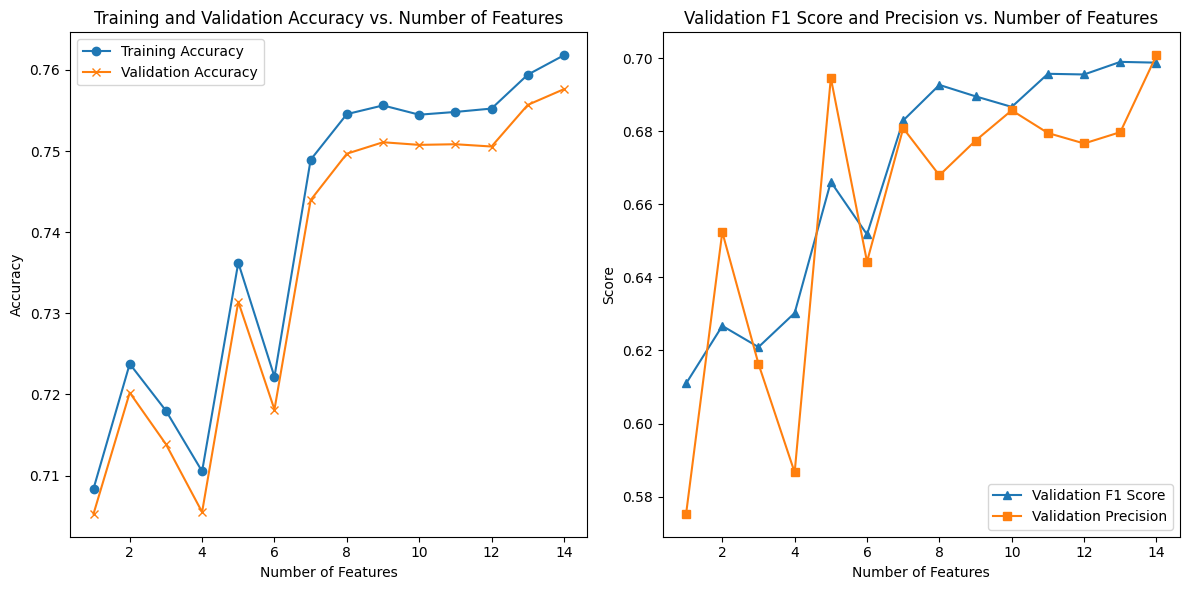

In [111]:
#Decision Tree RFE
# %%
train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = train_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns.difference(["Claim Injury Type"])

X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
precision_val = []
num_feature_list = list(range(1, num_features + 1))

# Use DecisionTreeClassifier as the base estimator for RFE
base_estimator = DecisionTreeClassifier(random_state=42)

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=200
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Evaluate precision on validation data
    precision_on_val = precision_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)
    precision_val.append(precision_on_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print(f"Validation Precision Score: {precision_on_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score and Precision
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.plot(num_feature_list, precision_val, label='Validation Precision', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Validation F1 Score and Precision vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()




In [113]:
# Random forest RFE with 200 estimators.

# %%
from sklearn.ensemble import RandomForestClassifier


train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = train_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns.difference(["Claim Injury Type"])

X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
precision_val = []
num_feature_list = list(range(1, num_features + 1))

# Use DecisionTreeClassifier as the base estimator for RFE
base_estimator = RandomForestClassifier(random_state=42, n_estimators=200)

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=200
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Evaluate precision on validation data
    precision_on_val = precision_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)
    precision_val.append(precision_on_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print(f"Validation Precision Score: {precision_on_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score and Precision
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.plot(num_feature_list, precision_val, label='Validation Precision', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Validation F1 Score and Precision vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()




KeyboardInterrupt: 

In [ ]:
# XGBoost estimator RFE

# %%
from sklearn.ensemble import XGBClassifier


train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = train_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns.difference(["Claim Injury Type"])

X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
precision_val = []
num_feature_list = list(range(1, num_features + 1))

# Use DecisionTreeClassifier as the base estimator for RFE
base_estimator = xgb_clf = XGBClassifier(
    n_estimators=200,         # Number of trees
    learning_rate=0.1,        # Step size shrinkage
    subsample=0.8,            # Row sampling
    colsample_bytree=0.8,     # Column sampling
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=200
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Evaluate precision on validation data
    precision_on_val = precision_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)
    precision_val.append(precision_on_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print(f"Validation Precision Score: {precision_on_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score and Precision
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.plot(num_feature_list, precision_val, label='Validation Precision', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Validation F1 Score and Precision vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()




# JÄIT TÄHÄN !!!! 


# PERJANTAINA --> LISÄÄ FIRST HEARING DATE DATAAN! (ÄLÄ DROPPAA!!) BINÄÄRINEN. JOS ON DATE NIIN 1 ja muuten 0  DONE!!!
# PERJANTAINA --> AJA EKAT JUTUT UUSIKSI DONE!!!


#   SUNNUNTAI --> Kaggle return (Logistic RFE kaikilla variableilla) DONE!!!!
# SUNNUNTAI --> TARGET ENCODING CATEGORISILLE VALUEILLE DONE!!!!
#   SUNNUNTAI --> SITTEN AJA UUSIKSI DONE!!!!


# MAANANTAINA --> Kaggle palautukset encodingilla DONE!!
# MAANANTAINA GRID SEARCH! JUOKSEE!
#   --> ERI ALPHAT (generalization)
#   --> ERI LAYER SUUNNITELMAT
#   --> EIR SOLVERIT Solver tuning
#   --> ERI ACTIVATION FUNKTIOT!
# MAANANTAINA AJOON ILLALLA--> RFEt (3kpl)

# TIISTAINA --> Parhaat featuret muodosta (5 eri feature pituutta)
# TIISTAINA --> SMOTE/OVERSAMPLING KOODAA VALMIIKSI
# TIISTAINA/KESKIVIIKKONA AJOON
# --> AJA OPTIMI MALLI (GRID SEARCHISTA) OPTIMI FEATUREILLA ILMAN SMOTEA JA SMOTEN/OVERSAMPLINGIN KANSSA

# TO/PE
# --> LAITA 1 VS REST MLP MALLIIIN MUKAAN JA KOKEILE OPTIMIMALLIA MUUTAMALLA ERI FEATURE SETILLÄ
# --> KOKEILE ROBUST SCALERIA KATEGORISILLE
# --> VIIMEISET MALLIT AJOON JA KAGGLE PALAUTUKSET. THAT'S IT


# JATKA!!!!
# JATKA!!!!
# JATKA!!!!
# JATKA!!!!
# JATKA!!!!
# JATKA!!!!
# JATKA!!!!
# JATKA!!!!



## RFE DT vs. Logistic Regression vs. Random Forest: Feature importances

* With Logistic Regression RFE these are ranked feature importances (In which order the features are selected in RFE process):
    1.
    2.
    3.
    4.
    5.
    6.
    7.
    8.
    9.
    10.
    11.
    12.
    13.
    14.
    15.
    16.
    17.
    18.
* With DT RFE these are ranked feature importances (In which order the features are selected in RFE process):
    1.
    2.
    3.
    4.
    5.
    6.
    7.
    8.
    9.
    10.
    11.
    12.
    13.
    14.
    15.
    16.
    17.
    18.
* With Random Forest RFE these are ranked feature importances (In which order the features are selected in RFE process).
    1.
    2.
    3.
    4.
    5.
    6.
    7.
    8.
    9.
    10.
    11.
    12.
    13.
    14.
    15.
    16.
    17.
    18.

* With XGBoost RFE these are ranked feature importances (In which order the features are selected in RFE process).
    1.
    2.
    3.
    4.
    5.
    6.
    7.
    8.
    9.
    10.
    11.
    12.
    13.
    14.
    15.
    16.
    17.
    18.

* TODO: Summary. Important features.
    * Based on the three RFE's ranks, we can form conclusions on which features to use ...

* TODO: Pearson's correlation matrix and chi_square (see from preprocessing):
    * SEE IF THE BEST FEATURES HAVE HIGH CORRELATIONS WITH EACH OTHER'S. DELETE SOME?...

* Based on these three different base model RFE methods, we will use these sets of features for future experiments:
    *
    *
    *
    *
    *

In [ ]:
#TODO: TREENAA EKAT MLP:T NÄILLÄ MALLEILLA JA KATSO TULOKSET. KATSO MYÖS KAGGLESTA TULOKSET.

 ## SMOTE/Oversampling tried again.

* **First time we tried this, we scaled data before applying SMOTE. This is wrong order and can lead to distorted synthetic samples**
 
 * Last time (also last time we tried, we didn't have wage column and also we potentially had leaky data preprocessing process) we tried SMOTE, it wasn't successcull. After less leaky data preprocessing, experimenting with different RFE methods and hyperparameter tuning, lets

 * We still have minority class members underpresneted, so trying this is still worth of shot

In [ ]:
# %%
#TODO:


 ## NN Model: Other experiments

 * Try Robust scaler (from ML practicals: Neural Networks) for data instead of standard scaler


#### Robust Scaler

In [ ]:
# %%
#TODO:

# Final NN Models with optimal feature sets

In [ ]:
#TODO: Treenaa viimeiset mallit

 # NN Model: Final Assessment and results

 * CLASSIFICATION TABLE!!
 * See precision, recall, f1-score, training and testing accuracy and confusion matrix and assess the quality of the model.